# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [4]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2, init_type="Noise"):   
    ''' Generate a random color/spin configuration for initialization'''
    if init_type=="Noise":
        return np.random.randint(low=1, high=no_colors+1, size=(N,N))
    elif init_type=="Uniform":
        color = np.random.randint(low=1, high=no_colors+1)
        return np.full((N, N), color)
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, cls, uf, config):
    '''Randomly sample a color for each cluster'''
    max_col = None
    for cluster in uf.components():
        for site_str in cluster:
            site = str2site(site_str)
            max_col = cluster_constraints[cls[site[0],site[1]]]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            break
        for site_str in cluster:
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    if prt: print("done sampling cluster colors")
    
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.uint16) # up to 255x255 box
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
            cluster_constraints[cl_n] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for cluster in uf.components():
            cluster_color = color_arr[i]
            for site_str in cluster:
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        '''Randomly sample a color for each cluster'''
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
        config = brute_force_sample (cluster_constraints, cls, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [5]:
def single_experiment (N, no_cols, gamma=0, J=0, alpha=0, iters=100):
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    param_name = "Alpha"

    '''Probabilities ordered from highest (high energy) to lowest'''
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)

    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)

    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)

    eta_prob = (lambda_prob, edge_prob, site_prob)

    '''Current states of eta'''
    eta_lambda = 0
    eta_edges = np.zeros((N,N,2), dtype=np.int8)
    # Special edge cases (no neighbors at the border)
    eta_edges[:,N-1,1] = -1
    eta_edges[N-1,:,0] = -1
    eta_sites = np.zeros((N,N), dtype=np.int8)
    eta = [eta_lambda, eta_edges, eta_sites]

    '''List of sites (tuples) for Union-Find'''
    sites = []
    for i in range(N):
        for j in range(N):
            sites.append(str(i)+','+str(j))

    config = initial_config(N, no_cols)
    print('\ninitial config:')
    print(config)
    for i in range(iters):
        print('\n' + '-'*50 + ' iter ' + str(i) + ' ' + '-'*50)
        config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)

    print('\nfinal config:')
    print(config)
    plt.imshow(config)
    plt.show()

    session.terminate()

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
edge probabilities: [0.32967995 0.67032005]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 7  2  9  6  6]
 [ 9  3 10  8  6]
 [ 8  8  8 10 10]
 [ 4  6  5  3  7]
 [ 2  2  3  5  4]]

-------------------------------------------------- iter 0 --------------------------------------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
current no. cols (lambda): 9
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  0 -1]
 [ 1  1  1  1 -1]
 [ 0  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 0  1  

Bell computed (24, 9)
partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 735471, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 47070144, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 235350720, (7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 823727520, (7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 2141691552, (7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 4283383104, (7, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 6731030592, (7, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 8413788240, (6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 1235591280, (6, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 11532185280, (6, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 37479602160, (6, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 89951045184, (6, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 164910249504, (6, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0): 235586070720, (6, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0): 132517164780, (6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 

partition_p: [8.518250979752574e-11, 5.3664981172441216e-09, 2.325482517472453e-08, 6.976447552417359e-08, 1.5348184615318188e-07, 2.5580307692196984e-07, 3.288896703282469e-07, 1.3952895104834717e-07, 1.1162316083867774e-06, 3.0696369230636376e-06, 6.139273846127275e-06, 9.208910769190914e-06, 5.262234725251951e-06, 2.0464246153757587e-06, 1.0232123076878792e-05, 1.8417821538381828e-05, 2.45570953845091e-05, 1.1511138461488642e-05, 3.6835643076763656e-05, 2.1487458461445463e-05, 2.5784950153734557e-05, 1.9534053146768604e-06, 2.1487458461445463e-05, 5.3718646153613664e-05, 9.669356307650459e-05, 0.00012892475076867278, 7.162486153815155e-05, 0.00032231187692168195, 0.0005156990030746911, 0.0003008244184602365, 0.00032231187692168195, 0.0009024732553807095, 0.0001804946510761419, 7.162486153815155e-05, 0.0004297491692289093, 0.000601648836920473, 0.0007520610461505912, 0.0009024732553807095, 0.0003760305230752956, 1.6115593846084097e-05, 0.00021487458461445465, 0.00048346781538252296, 

partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 125970, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 6046560, (7, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0): 22170720, (7, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0): 55426800, (7, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0): 99768240, (7, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0): 133024320, (6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 116396280, (6, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0): 775975200, (6, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0): 1745944200, (6, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0): 2793510720, (6, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0): 1629547920, (6, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1163962800, (6, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0): 4655851200, (6, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0): 6518191680, (6, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0): 4073869800, (6, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0): 4888643760, (5, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 1163962800, (5, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0): 10475665200, (5, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0): 20951330400, (5, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0): 2933186256

current no. cols (lambda): 8
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  0  0 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  3  3]
 [ 4  5  6  7  8]
 [ 9 10 11 12 13]
 [14 15 16 17 18]
 [19 20 21 22 23]]
Case with no field and gamma > 0
prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000]
prob_k: [4.88271721e-22 1.84316359e-14 5.51461971e-10 7.17679675e-07
 1.42362783e-04 7.37506323e-03 1.29422371e-01 8.63059485e-01]
exact number of colors to use in configurat

(1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
chosen partition:
[1, 3, 3, 4, 6, 6]
colors for clusters:
[ 3  7  9  3  2  3  2  7  2  3  7  6  7  6  9  7 10  6  7  2  3  9  3]
config:
[[ 3  7  9  3  2]
 [ 3  2  7  7  2]
 [ 3  7  6  7  6]
 [ 9  9  7 10  6]
 [ 7  2  3  9  3]]

-------------------------------------------------- iter 29 --------------------------------------------------
probabilities for no. of colors (lambda): [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 1.23409804e-04]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 7
probabilities for edges: [0.32967995 0.67032005]
assigned bonds (eta_edges):
[[ 1  1  1  1  1]
 [ 0  1  1  0  1]
 [ 1  1  1  1  1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

[[ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]
 [ 1  1  1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (

prob_k: [10, 377487270, 11294161560720, 14698366576740000, 2915646698687184000, 151044242527090836000, 2650621881066146064000, 17675803188107285760000]
prob_k: [4.88271721e-22 1.84316359e-14 5.51461971e-10 7.17679675e-07
 1.42362783e-04 7.37506323e-03 1.29422371e-01 8.63059485e-01]
exact number of colors to use in configuration:
8
Bell found (23, 8)
partition_dict {(7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 245157, (6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 13728792, (6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 68643960, (6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 240253860, (6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 624660036, (6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1249320072, (6, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0): 1963217256, (6, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0): 2454021570, (5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 308897820, (5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 2883046320, (5, 1, 0, 1, 0, 0, 0, 0

partition_p: [4.248951261681657e-12, 2.294433681308095e-10, 1.3001790860745871e-09, 5.2007163442983486e-09, 1.5602149032895048e-08, 3.640501441008844e-08, 6.760931247587853e-08, 1.014139687138178e-07, 1.2395040620577732e-07, 4.875671572779702e-09, 5.200716344298349e-08, 1.950268629111881e-07, 5.460752161513266e-07, 1.1831629683278743e-06, 2.028279374276356e-06, 2.7888841396299895e-06, 1.5493800775722165e-06, 1.300179086074587e-07, 9.10125360252211e-07, 2.3663259366557485e-06, 4.732651873311497e-06, 7.437024372346639e-06, 9.296280465433298e-06, 1.478953710409843e-06, 7.098977809967246e-06, 1.3014792651606618e-05, 1.8592560930866596e-05, 1.0458315523612462e-05, 7.808875590963971e-06, 2.6029585303213236e-05, 3.3466609675559876e-05, 1.9522188977409927e-05, 2.2311073117039916e-05, 5.200716344298349e-08, 7.801074516447524e-07, 2.730376080756633e-06, 7.098977809967246e-06, 1.4197955619934492e-05, 2.2311073117039916e-05, 2.7888841396299894e-05, 3.640501441008844e-06, 2.3663259366557488e-05, 5.

probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 18 23 24]]
Case with no field and gamma > 0
prob_k: [10, 754974630, 33885504580320, 58872525437885040, 14666423692896360000, 920843688655980936000, 19158530137571385792000, 149358291148056724272000, 437715197714451888000000]
prob_k: [1.64699174e-23 1.24343698e-15 5.58091460e-11 9.69625629e-08
 2.41554786e-05 1.51662195e-03 3.15539408e-02 2.45991871e-01
 7.20913313e-01]
exact number of colors to use in configuration:
9
Bell found (24, 9)
partition_dict {(8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 735471, (7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 47070144, (7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 235350720, (7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0): 8237275

partition_p: [116280, 5697720, 24690120, 74070360, 162954792, 271591320, 349188840, 111105540, 888844320, 2444321880, 4888643760, 7332965640, 4190266080, 1629547920, 8147739600, 14665931280, 19554575040, 9166207050, 29331862560, 17110253160, 20532303792, 1111055400, 12221609400, 30554023500, 54997242300, 73329656400, 40738698000, 183324141000, 293318625600, 171102531600, 183324141000, 513307594800, 102661518960, 40738698000, 244432188000, 342205063200, 427756329000, 513307594800, 213878164500, 6110804700, 81477396000, 183324141000, 293318625600, 171102531600, 366648282000, 1466593128000, 2053230379200, 1283268987000, 1539922784400, 651819168000, 3422050632000, 2053230379200, 5133075948000, 534695411250, 380227848000, 2281367088000, 1425854430000, 18332414100, 274986211500, 549972423000, 769961392200, 1466593128000, 5133075948000, 3079845568800, 3849806961000, 3422050632000, 15399227844000, 6416344935000, 3422050632000, 8555126580000, 1140683544000, 27498621150, 439977938400, 7699613922

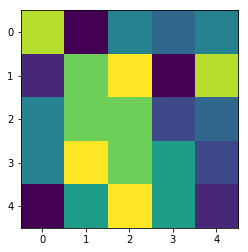

In [6]:
only_averages = False
prt = True
N, no_cols = 5, 10
gamma = 1    # strength of preference for low no. of cols
J = .2        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

## Full simulation

In [7]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [8]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.full(nparam, 1, dtype='float'), np.full(nparam, N*N, dtype='float')
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    converge_cnt = 0
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
        
        if (avg_c[iparam]==1 and std_c[iparam]==0):
            converge_cnt += 1
            if converge_cnt == 2:
                break
        
#         df_config = pd.DataFrame(config)
#         df_config.to_csv("Simulation_all_interaction_data/final_config_("
#                     + str(N)+ "," + str(no_cols)
#                     + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
#                     + "_vary_" + param_name + "_" + str(param) +"_steps_" + str((eq_steps, mc_steps)) + ".csv")
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / " + str(no_cols) + " colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_steps_" + str((eq_steps, mc_steps)) + ".png", format="png")
    
    # plt.show()
    
    df = pd.DataFrame([params, avg_c, std_c, avg_s_c, std_s_c], index=['params', 'avg_c', 'std_c', 'avg_s_c', 'std_s_c']).T
    df.to_csv("Simulation_all_interaction_data/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_steps_" + str((eq_steps, mc_steps)) + ".csv")
    
    
    
    print(df.head())
    
    return params, avg_c, std_c

In [9]:
def plot_multiple (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / " + str(no_cols) + " colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")

    plt.show()

## J and Gamma phase diagram

In [10]:
import matplotlib.cm as cm

def save_to_csv_multiple (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    
    full_results = []
    for i in range(len(params2)):
        tmp = [[params[i][j], params2[i], avg_c[i][j], std_c[i][j]] for j in range(len(params[i]))]
        for t in tmp: full_results.append(t)
    full_results = np.array(full_results)
    df = pd.DataFrame(full_results, columns=[param_name, param_name2, "Avg. no. of colors", "Std."])
    df.to_csv("Simulation_all_interaction_data/avg_std_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".csv")
    print(df)
    
def plot_phase (N, no_cols, params, avg_c, std_c, params2, param_name, param_name2, save_opts=""):
    df = pd.read_csv("Simulation_all_interaction_data/avg_std_("
                        + str(N)+ "," + str(no_cols) + ")"
                        + "_vary_" + param_name
                        + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                        + save_opts + ".csv")
    df.plot.scatter(x=param_name2,
                    y=param_name,
                    c="Avg. no. of colors",
                    cmap="inferno",
                    title = str(N*N) + " total sites / " + str(no_cols) + " colors",
                    figsize = (8,8))
    plt.savefig("Simulation_all_interaction/phase_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")
    plt.show()

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 10.168316831683168 avg. sites per col: 1.5938771899167923
201 num. cols: 10.303482587064677 avg. sites per col: 1.5739614724689348
301 num. cols: 10.23920265780731 avg. sites per col: 1.5844049638069566
401 num. cols: 10.199501246882793 avg. sites per col: 1.5921170544612007
501 num. cols: 10.239520958083832 avg. sites 

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 8.94059405940594 avg. sites per col: 1.8355035503550339
201 num. cols: 9.029850746268657 avg. sites per col: 1.8171431663968964
301 num. cols: 8.986710963455149 avg. sites per col: 1.824658766851459
401 num. cols: 8.98503740648379 avg. sites per col: 1.8244253945002156
501 num. cols: 8.930139720558882 avg. sites per col: 1.840685284996674
601 num. cols: 8.89018302828619 avg. sites per col: 1.85193759836024
701 num. cols: 8.927246790299572 avg. sites per col: 1.8422883187505248
801 num. cols: 8.932584269662922 avg. sites per col: 1.8418296920169643
901 num. cols: 8.974472807991122 avg. sites per col: 1.833022619260137
1001 num. cols: 8.957042957042956 avg. sites per col: 1.8368985881473425
Final configuration:
[[ 1  9  6 14]
 [ 1  6 11 14]
 [14 15  2  5]
 [11 12  3 12]]
Final averages: 8.960199004975124 1.836132601505

701 num. cols: 1.5706134094151212 avg. sites per col: 12.319163100332846
801 num. cols: 1.5905118601747816 avg. sites per col: 12.237702871410738
901 num. cols: 1.6514983351831298 avg. sites per col: 11.917425083240857
1001 num. cols: 1.6343656343656343 avg. sites per col: 11.984282384282402
Final configuration:
[[ 9  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9 14]
 [ 9  9  9  7]]
Final averages: 1.6388059701492537 11.960464344941977
Final stds: 0.8368898636884406 4.584164610878384
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.504950495049505 avg. sites per col: 7.490429042904291
201 num. cols: 2.2238805970149254 avg. sites per col: 8.168490878938638
301 num.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]
 [7 7 7 7]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168436 0.01831564]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
e

501 num. cols: 8.315369261477047 avg. sites per col: 1.9689118156184113
601 num. cols: 8.26955074875208 avg. sites per col: 1.980320437558381
701 num. cols: 8.24679029957204 avg. sites per col: 1.9876037736237506
801 num. cols: 8.244694132334581 avg. sites per col: 1.9882967358622836
901 num. cols: 8.246392896781353 avg. sites per col: 1.9862351484993037
1001 num. cols: 8.218781218781219 avg. sites per col: 1.9953433623763324
Final configuration:
[[16 10  8 14]
 [ 8  5 12 14]
 [11 11 12  5]
 [16 10 16 12]]
Final averages: 8.212935323383084 1.9968781246393215
Final stds: 1.2869153372965814 0.31792782785098467
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0891089108910892 avg. sites per col: 15.287128712871286
201 num. cols: 1.208955223880597 avg. sites per col: 14.43449419568823
301 num. cols: 1.458471760797342 avg. sites per col: 13.138427464008876
401 num. cols: 1.6683291770573565 avg. sites per col: 11.851704073150454
501 num. cols: 1.5548902195608783 avg. sites per col: 12.520026613439784
601 num. cols: 1.4941763727121464 avg. sites per col: 12.846145313366609
701 num. cols: 1.6619115549215406 avg. sites per col: 12.19400855920113
801 num. cols: 1.7652933832709115 avg. sites per col: 11.705368289637969
901 num. cols: 1.7880133185349611 avg. sites per col: 11.563743988161326
1001 num. cols: 1.8861138861138862 avg. sites per col: 11.063869463869514
Final configuration:
[[12 12 12 15]
 [12 12 12 12]
 [12 12 12 12]
 [12 12 12 12]]
Final averages: 1.886567

701 num. cols: 1.0313837375178316 avg. sites per col: 15.748930099857347
801 num. cols: 1.0274656679151062 avg. sites per col: 15.78027465667915
901 num. cols: 1.0244173140954496 avg. sites per col: 15.804661487236404
1001 num. cols: 1.021978021978022 avg. sites per col: 15.824175824175825
Final configuration:
[[13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]
 [13 13 13 13]]
Final averages: 1.0218905472636817 15.824875621890547
Final stds: 0.14632618085694066 1.1706094468555253
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 3.2
101 num. cols: 6.594059405940594 avg. sites per col: 2.5225836869401204
201 num. cols: 6.870646766169155 avg. sites per col: 2.4036326304983024
301 num. cols: 6.930232558139535 avg. sites per col: 2.3679797500395554
401 num. cols: 6.870324189526184 avg. sites per col: 2.4021850136563425
501 num. cols: 6.8902195608782435 avg. sites per col: 2.3994804042708324
601 num. cols: 6.821963394342762 avg. sites per col: 2.4188046377730323
701 num. cols: 6.81169757489301 avg. sites per col: 2.415442791477036
801 num. cols: 6.84769038701623 avg. sites per col: 2.4018627509264294
901 num. cols: 6.710321864594895 avg. sites per col: 2.462878988073216
1001 num. cols: 6.7742257742257745 avg. sites per col: 2.4395350681064896
Final configuration:
[[ 6  9 15 11]
 [13 15  9  8]
 [ 4  9 11  9]
 [ 1  8  9  3]]
Final averages: 6.783084577114428

701 num. cols: 3.5549215406562054 avg. sites per col: 5.564295903810877
801 num. cols: 3.588014981273408 avg. sites per col: 5.483146067415712
901 num. cols: 3.4550499445061043 avg. sites per col: 5.734369219385842
1001 num. cols: 3.6663336663336663 avg. sites per col: 5.455268540982811
Final configuration:
[[ 1 16 16 16]
 [ 1 10 16 16]
 [ 1 16 16 16]
 [16 16 16 16]]
Final averages: 3.664676616915423 5.453456526889346
Final stds: 1.5245898298082416 3.0862976513830387
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 1.8613861386138615 avg. sites per col: 9.267326732673268
201 num. cols: 2.1393034825870645 avg. sites per col: 8.252072968490866
301 num. cols:

101 num. cols: 1.1683168316831682 avg. sites per col: 14.653465346534654
201 num. cols: 1.5522388059701493 avg. sites per col: 11.927031509121072
301 num. cols: 1.3687707641196014 avg. sites per col: 13.280177187153939
401 num. cols: 1.2942643391521198 avg. sites per col: 13.818786367414802
501 num. cols: 1.2455089820359282 avg. sites per col: 14.17431803060546
601 num. cols: 1.204658901830283 avg. sites per col: 14.47809206877427
701 num. cols: 1.1754636233951499 avg. sites per col: 14.695197337137426
801 num. cols: 1.1535580524344569 avg. sites per col: 14.858094049105288
901 num. cols: 1.1431742508324085 avg. sites per col: 14.93155752867185
1001 num. cols: 1.141858141858142 avg. sites per col: 14.934398934398937
Final configuration:
[[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 1.1412935323383084 14.938640132669986
Final stds: 0.3836669347544052 2.780707150708685
---------------------------------------------------------------------------------------------------------

901 num. cols: 5.833518312985571 avg. sites per col: 2.8034036256011836
1001 num. cols: 5.915084915084915 avg. sites per col: 2.767004424147271
Final configuration:
[[14 16 16 12]
 [ 9 12 12 16]
 [ 3  1 14  6]
 [ 3  1  3  4]]
Final averages: 5.9233830845771145 2.7639516702203166
Final stds: 0.9288630494798427 0.4049634601217071
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 5.333333333333333
101 num. cols: 5.564356435643564 avg. sites per col: 3.0461103253182427
201 num. cols: 5.45273631840796 avg. sites per col: 3.1114901682065863
301 num. cols: 5.74750830564784 avg. sites per col: 2.9211833570637538
401 num. cols: 5.910224438902743 avg. sites per col: 2.855100344377159
5

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0049751243781095 avg. sites per col: 15.960199004975124
301 num. cols: 1.2956810631229236 avg. sites per col: 13.935769656699899
401 num. cols: 1.5361596009975063 avg. sites per col: 12.83790523690772
501 num. cols: 1.620758483033932 avg. sites per col: 12.20492348636059
601 num. cols: 1.5540765391014975 avg. sites per col: 12.543538546866314
701 num. cols: 1.529243937232525 avg. sites per col: 12.656205420827378
801 num. cols: 1.6217228464419475 avg. sites per col: 12.211069496462777
901 num. cols: 1.60488346281909 avg. sites per col: 12.232038475767686
1001 num. cols: 1.5574425574425574 avg. sites per col: 12.504562104562124
Final configuration:
[[8 7 7 7]
 [8 7 7 7]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 1.5592039800995026 12.486633499170832
Final stds: 0.810213019826636 4.5136725401

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0 avg. sites per col: 16.0
301 num. cols: 1.0 avg. sites per col: 16.0
401 num. cols: 1.0 avg. sites per col: 16.0
501 num. cols: 1.0 avg. sites per col: 16.0
601 num. cols: 1.0 avg. sites per col: 16.0
701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]
 [11 11 11 11]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibrat

401 num. cols: 2.7680798004987532 avg. sites per col: 6.167913549459673
501 num. cols: 2.8682634730538923 avg. sites per col: 6.059880239520945
601 num. cols: 3.033277870216306 avg. sites per col: 5.769305126376667
701 num. cols: 3.1184022824536375 avg. sites per col: 5.636356225799873
801 num. cols: 3.292134831460674 avg. sites per col: 5.381130729445321
901 num. cols: 3.3662597114317423 avg. sites per col: 5.247967866391812
1001 num. cols: 3.323676323676324 avg. sites per col: 5.28180391037529
Final configuration:
[[16  2 16 16]
 [ 4  4 14  4]
 [ 4 16 16 16]
 [ 4 16  2  4]]
Final averages: 3.32636815920398 5.276702203269318
Final stds: 0.9889696350675617 1.6434409477001348
------------------------------------------------------------------------------------------------------------------------

5  - param: 0.5
edge probabilities: [0.63212056 0.36787944]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibratio

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.1890547263681592 avg. sites per col: 14.487562189054726
301 num. cols: 1.132890365448505 avg. sites per col: 14.93687707641196
401 num. cols: 1.0997506234413965 avg. sites per col: 15.201995012468828
501 num. cols: 1.0798403193612773 avg. sites per col: 15.361277445109781
601 num. cols: 1.0665557404326123 avg. sites per col: 15.467554076539102
701 num. cols: 1.0570613409415122 avg. sites per col: 15.543509272467903
801 num. cols: 1.0499375780274656 avg. sites per col: 15.600499375780275
901 num. cols: 1.044395116537181 avg. sites per col: 15.644839067702552
1001 num. cols: 1.03996003996004 avg. sites per col: 15.68031968031968
Final configuration:
[[10 10 10 10]
 [10 10 10 10]
 [10 10 10 10]
 [10 10 10 10]]
Final averages: 1.0398009950248757 15.681592039800995
F

501 num. cols: 2.4810379241516967 avg. sites per col: 6.810379241516988
601 num. cols: 2.4009983361064893 avg. sites per col: 7.008319467554094
701 num. cols: 2.3437945791726107 avg. sites per col: 7.149786019971485
801 num. cols: 2.3008739076154807 avg. sites per col: 7.255930087390775
901 num. cols: 2.267480577136515 avg. sites per col: 7.338512763596016
1001 num. cols: 2.247752247752248 avg. sites per col: 7.385947385947395
Final configuration:
[[13 13  7  5]
 [ 7  5  7 13]
 [ 7  5  7  5]
 [ 7  5  7  7]]
Final averages: 2.2507462686567163 7.377777777777785
Final stds: 0.5074685396209134 1.2074091030859637
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 4.0
101 num. cols:

701 num. cols: 1.0 avg. sites per col: 16.0
801 num. cols: 1.0 avg. sites per col: 16.0
901 num. cols: 1.0 avg. sites per col: 16.0
1001 num. cols: 1.0 avg. sites per col: 16.0
Final configuration:
[[8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 1.0 16.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c    avg_s_c   std_s_c
0     0.0  3.526368  0.973556   4.889685  1.358550
1     0.1  3.548259  0.497666   4.602322  0.663554
2     0.2  2.250746  0.507469   7.377778  1.207409
3     0.3  2.568159  0.660605   6.966501  3.046622
4     0.4  1.155224  0.362118  14.758209  2.896944
GAMMA: 8 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [9.99664537e-01 3.35350093e-04 1.12497423e-07 3.773868

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[12 12  9 12]
 [ 9  9  9 12]
 [ 9 12 12  9]
 [ 9  9  9  9]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 300

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.0 avg. sites per col: 8.0
Final configuration:
[[10 10  9 10]
 [ 9 10  9  9]
 [10 10  9 10]
 [10 10 10  9]]
Final averages: 2.0 8.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 300

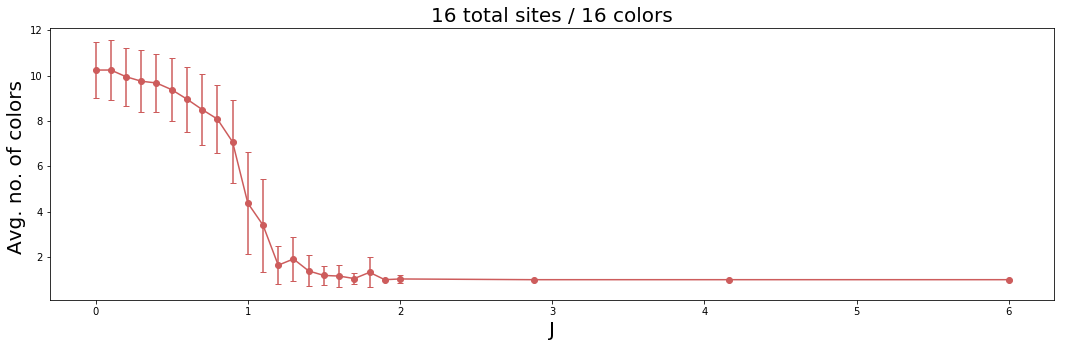

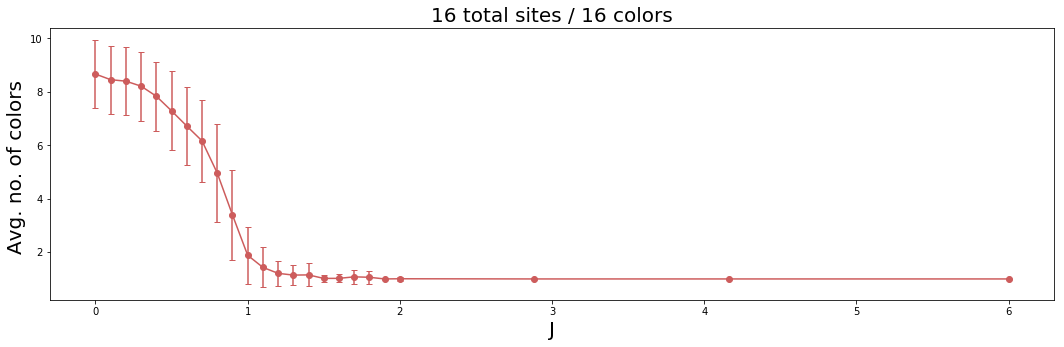

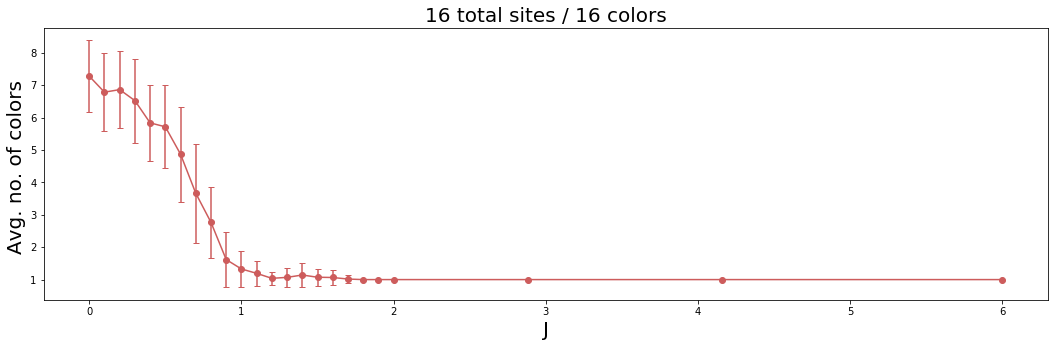

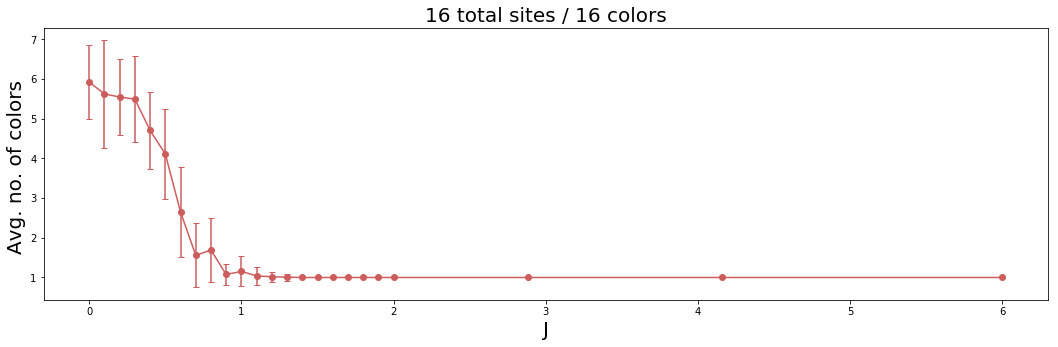

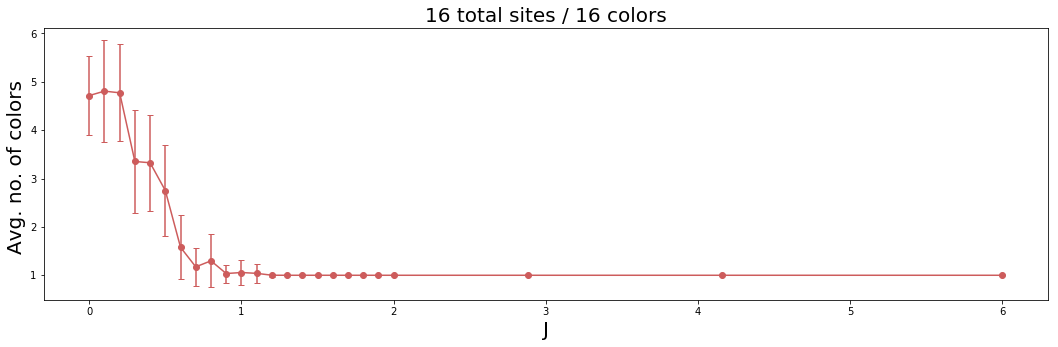

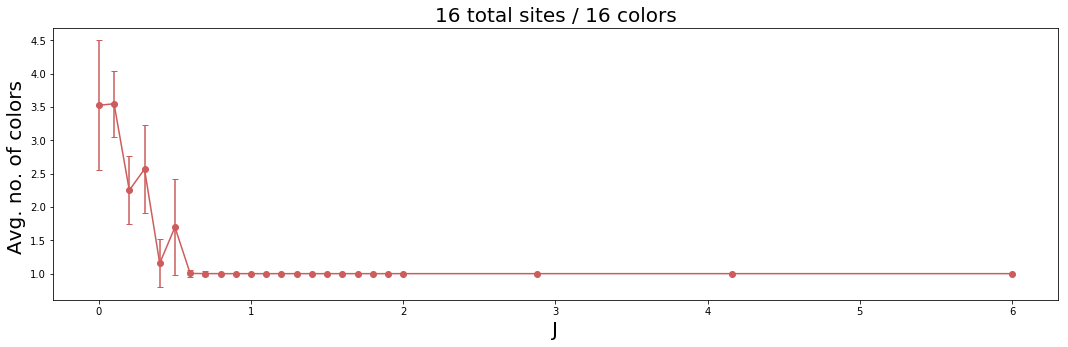

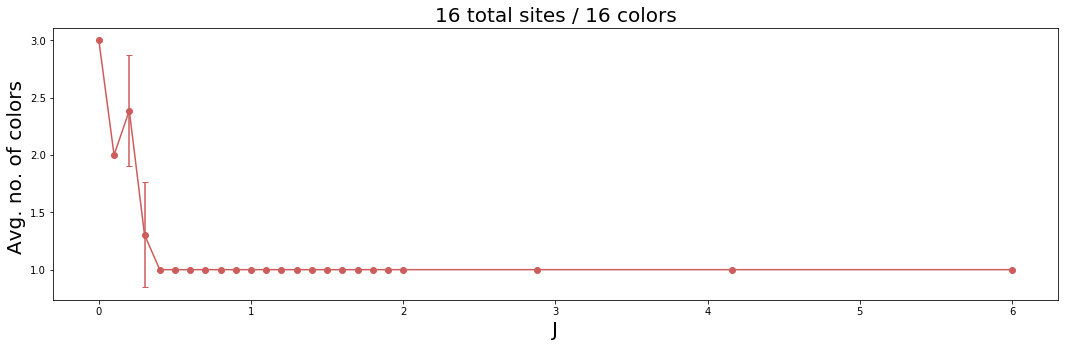

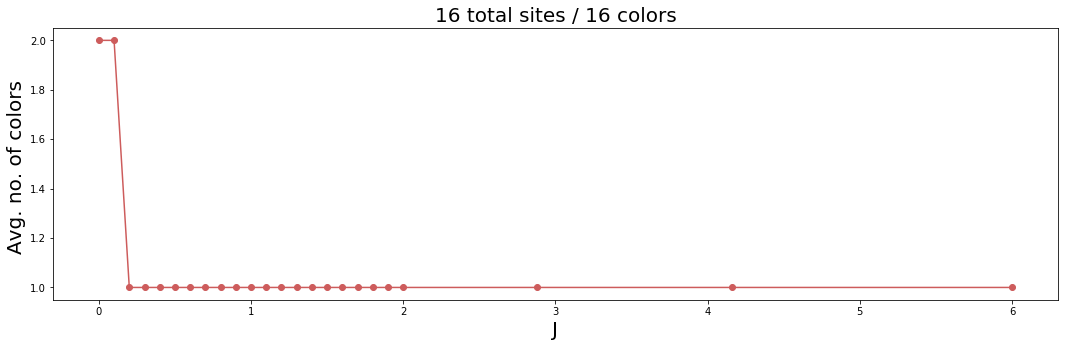

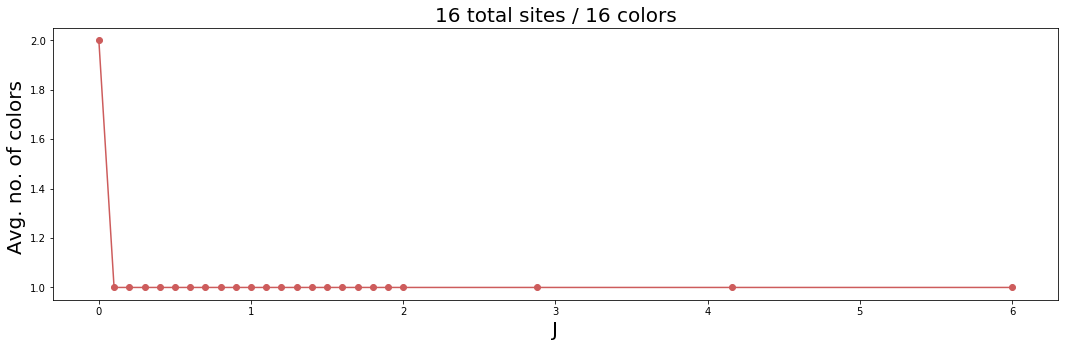

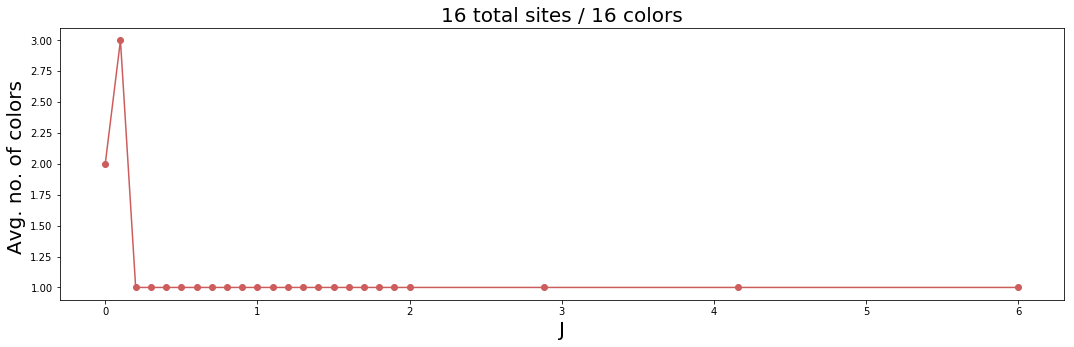

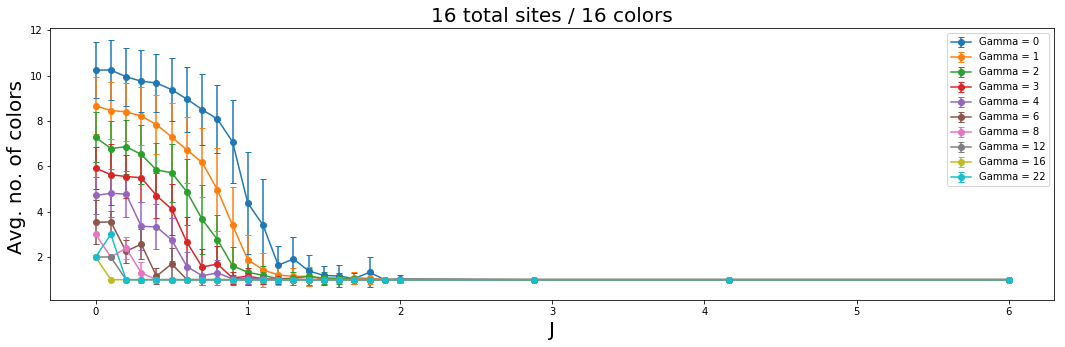

        J  Gamma  Avg. no. of colors      Std.
0    0.00    0.0           10.240796  1.232934
1    0.10    0.0           10.242786  1.307750
2    0.20    0.0            9.947264  1.269702
3    0.30    0.0            9.749254  1.354856
4    0.40    0.0            9.671642  1.284288
5    0.50    0.0            9.376119  1.378523
6    0.60    0.0            8.960199  1.431142
7    0.70    0.0            8.501493  1.545736
8    0.80    0.0            8.081592  1.507959
9    0.90    0.0            7.074627  1.825034
10   1.00    0.0            4.378109  2.256735
11   1.10    0.0            3.405970  2.047779
12   1.20    0.0            1.638806  0.836890
13   1.30    0.0            1.913433  0.952331
14   1.40    0.0            1.386070  0.682551
15   1.50    0.0            1.187065  0.426523
16   1.60    0.0            1.160199  0.491933
17   1.70    0.0            1.049751  0.230751
18   1.80    0.0            1.324378  0.666358
19   1.90    0.0            1.000000  0.000000
20   2.00    

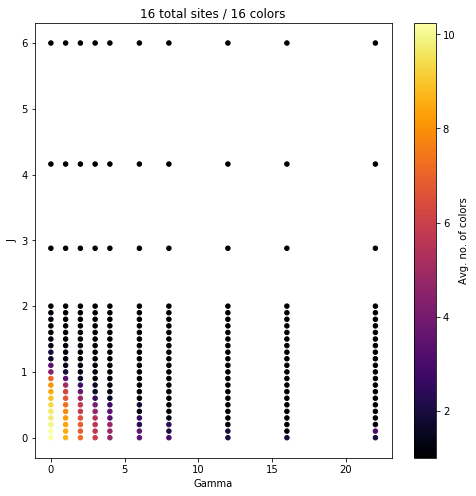

In [110]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 4

params, avg_c, std_c = [], [], []
gammas = [0,1,2,3,4,6,8,12,16,22]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
save_to_csv_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 16.0 avg. sites per col: 1.5625
101 num. cols: 16.08910891089109 avg. sites per col: 1.5700059452837392
201 num. cols: 15.970149253731343 avg. sites per col: 1.5819575559190184
301 num. cols: 15.906976744186046 avg. sites per col: 1.5876696063354607
401 num. cols: 15.86783042394015 avg. sites per col: 1.5911802039217653
5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 14.762376237623762 avg. sites per col: 1.7173733467739998
201 num. cols: 14.621890547263682 avg. sites per col: 1.733375632773766
301 num. cols: 14.501661129568106 avg. sites per col: 1.751079093978922
401 num. cols: 14.498753117206983 avg. sites per col: 1.7538203173090412
501 num. cols: 14.37125748502994 avg. sites per col: 1.7703467638292278
601 num. cols: 14.480865224625624 avg. sites per col: 1.7563585783573905
701 num. cols: 14.445078459343794 avg. sites per col: 1.761840153159995
801 num. cols: 14.454431960049938 avg. sites per col: 1.760206914346187
901 num. cols: 14.4173140954495 avg. sites per col: 1.7656542533989925
1001 num. cols: 14.443556443556444 avg. sites per col: 1.7620158604599854
Final configuration:
[[16 25 19  4 20]
 [16 16  1 16 14]
 [ 4 12 20 13 21]
 [14  2 22 13 16]
 

301 num. cols: 2.6710963455149503 avg. sites per col: 11.08665559246958
401 num. cols: 3.311720698254364 avg. sites per col: 9.613614772592344
501 num. cols: 3.287425149700599 avg. sites per col: 9.808121851535034
601 num. cols: 3.196339434276206 avg. sites per col: 9.796371127485921
701 num. cols: 3.182596291012839 avg. sites per col: 9.611439440255378
801 num. cols: 3.009987515605493 avg. sites per col: 10.523452826823574
901 num. cols: 2.8546059933407326 avg. sites per col: 11.348633793139868
1001 num. cols: 2.9510489510489513 avg. sites per col: 11.369088162919304
Final configuration:
[[14  2  2 15 10]
 [14  2  2  1 24]
 [14  2  2  2  2]
 [13  2  2  2 20]
 [14 20 23  1 20]]
Final averages: 2.9800995024875623 11.333612421298962
Final stds: 1.63409018611823 6.630774292449824
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
equilibration step: 0
equilib

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.1627906976744187 avg. sites per col: 22.96511627906977
401 num. cols: 1.1221945137157108 avg. sites per col: 23.472568578553616
501 num. cols: 1.0978043912175648 avg. sites per col: 23.777445109780437
601 num. cols: 1.08153078202995 avg. sites per col: 23.980865224625624
701 num. cols: 1.0998573466476462 avg. sites per col: 23.75178316690442
801 num. cols: 1.104868913857678 avg. sites per col: 23.689138576779026
901 num. cols: 1.097669256381798 avg. sites per col: 23.779134295227525
1001 num. cols: 1.0879120879120878 avg. sites per col: 23.9010989010989
Final configuration:
[[5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 1.0875621890547265 23.90547263681592
Final stds: 0.28265712816532

301 num. cols: 14.142857142857142 avg. sites per col: 1.7813808995165237
401 num. cols: 13.88778054862843 avg. sites per col: 1.8166454611188356
501 num. cols: 13.754491017964073 avg. sites per col: 1.8362692395142217
601 num. cols: 13.67054908485857 avg. sites per col: 1.8512487147176888
701 num. cols: 13.650499286733238 avg. sites per col: 1.8549595322535208
801 num. cols: 13.64669163545568 avg. sites per col: 1.855747582711116
901 num. cols: 13.571587125416205 avg. sites per col: 1.8658792844950296
1001 num. cols: 13.544455544455545 avg. sites per col: 1.869012848346005
Final configuration:
[[ 5 20 25 12  8]
 [ 8  7 19 14  8]
 [ 5 25 13 14 14]
 [13  7 25 14 14]
 [ 1  7  1  8  2]]
Final averages: 13.533333333333333 1.8708458139428186
Final stds: 1.5075707233505877 0.21356810642490714
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
equilibration step: 0

701 num. cols: 11.081312410841655 avg. sites per col: 2.313277446123377
801 num. cols: 11.062421972534333 avg. sites per col: 2.3218782229577517
901 num. cols: 11.052164261931187 avg. sites per col: 2.32331583873171
1001 num. cols: 11.074925074925074 avg. sites per col: 2.3169834485540877
Final configuration:
[[ 6 14 20 20 24]
 [12 20 20 20 24]
 [20 20 19  1  4]
 [ 6 14 19 22 14]
 [ 6  1 19 24 14]]
Final averages: 11.066666666666666 2.31881745583458
Final stds: 1.6870986409253823 0.4047531348698545
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 2.5
101 num. cols: 9.594059405940595 avg. sites per col: 2.696471570233946
201 num. cols: 8.955223880597014 avg. sites per col: 2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0249376558603491 avg. sites per col: 24.688279301745634
501 num. cols: 1.129740518962076 avg. sites per col: 23.378243512974052
601 num. cols: 1.1464226289517472 avg. sites per col: 23.169717138103163
701 num. cols: 1.2524964336661912 avg. sites per col: 21.84379457917261
801 num. cols: 1.223470661672909 avg. sites per col: 22.20661672908864
901 num. cols: 1.1986681465038846 avg. sites per col: 22.516648168701444
1001 num. cols: 1.1788211788211789 avg. sites per col: 22.764735264735265
Final configuration:
[[3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]
Final averages: 1.1781094527363185 22.77363184079602
Final stds: 0.382604855670034 4.782560695875425
-----

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params      avg_c     std_c   avg_s_c   std_s_c
0     0.0  13.440796  1.528413  1.884779  0.221149
1     0.1  13.533333  1.507571  1.87

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 9.336633663366337 avg. sites per col: 2.7617047419027627
201 num. cols: 8.970149253731343 avg. sites per col: 2.8435877969460055
301 num. cols: 8.986710963455149 avg. sites per col: 2.8324835924503735
401 num. cols: 8.99002493765586 avg. sites per col: 2.8297986994994555
501 num. cols: 9.253493013972056 avg. sites per col: 2.758687171112324
601 num. cols: 9.29118136439268 avg. sites per col: 2.7535426765876045
701 num. cols: 9.51925820256776 avg. sites per col: 2.6927225572018725
801 num. cols: 9.622971285892634 avg. sites per col: 2.6608413780698448
901 num. cols: 9.748057713651498 avg. sites per col: 2.6273399802811706
1001 num. cols: 9.823176823176823 avg. sites per col: 2.6077367798147253
Final configuration:
[[ 6  8  3 12  5]
 [15 15  4  5  5]
 [16  6 17 17  5]
 [19 19  6 15  6]
 [19 12 1

401 num. cols: 1.199501246882793 avg. sites per col: 22.58935993349958
501 num. cols: 1.1616766467065869 avg. sites per col: 23.045575515635395
601 num. cols: 1.1580698835274543 avg. sites per col: 23.079589572933997
701 num. cols: 1.1997146932952925 avg. sites per col: 22.634331906799815
801 num. cols: 1.250936329588015 avg. sites per col: 22.081772784019986
901 num. cols: 1.271920088790233 avg. sites per col: 21.795227524972262
1001 num. cols: 1.2737262737262738 avg. sites per col: 21.75324675324676
Final configuration:
[[25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]]
Final averages: 1.272636815920398 21.766169154228862
Final stds: 0.48999696662459497 5.60502467226449
------------------------------------------------------------------------------------------------------------------------

12  - param: 1.2
edge probabilities: [0.90928205 0.09071795]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000

101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites 

301 num. cols: 8.76079734219269 avg. sites per col: 2.9234262415325567
401 num. cols: 8.925187032418952 avg. sites per col: 2.881878096965386
501 num. cols: 8.676646706586826 avg. sites per col: 2.9857114774779547
601 num. cols: 8.627287853577371 avg. sites per col: 2.987742290986894
701 num. cols: 8.728958630527817 avg. sites per col: 2.945803305111448
801 num. cols: 8.64669163545568 avg. sites per col: 2.973005199128803
901 num. cols: 8.571587125416205 avg. sites per col: 2.998187840030243
1001 num. cols: 8.595404595404595 avg. sites per col: 2.984058690227529
Final configuration:
[[16  2  7 24 11]
 [ 7  1 16 11 16]
 [ 9  6  1 16  6]
 [24  2  2 20  2]
 [20 24 16  9  7]]
Final averages: 8.597014925373134 2.983237671670515
Final stds: 1.305857848760832 0.5095288428548853
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration 

901 num. cols: 1.239733629300777 avg. sites per col: 22.78671846096931
1001 num. cols: 1.2157842157842158 avg. sites per col: 23.007825507825526
Final configuration:
[[13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]
 [13 13 13 13 13]]
Final averages: 1.2149253731343284 23.0157545605307
Final stds: 0.6257939191592561 5.047558561004405
------------------------------------------------------------------------------------------------------------------------

10  - param: 1.0
edge probabilities: [0.86466472 0.13533528]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.00990099009901 avg. sites per col: 24.876237623762375
201 num. cols: 1.0049751243781095 avg. sites per col: 24.937810945273633
301 num. cols: 1.0365448504983388 avg. sites per col: 24.543189368770765
401 num. cols: 1.3591022443890275 avg. sites per col:

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 8.504950495049505 avg. sites per col: 2.9581172402954556
201 num. cols: 8.82089552238806 avg. sites per col: 2.8580312722103747
301 num. cols: 8.318936877076412 avg. sites per col: 3.049062648315135
401 num. cols: 7.840399002493766 avg. sites per col: 3.2683915211970165
501 num. cols: 7.538922155688622 avg. sites per col: 3.4084806577321785
601 num. cols: 7.422628951747088 avg. sites per col: 3.46150925705837
701 num. cols: 7.4950071326676175 avg. sites per col: 3.4210764667255598
801 num. cols: 7.52808988764045 avg. sites per col: 3.3974892495491886
901 num. cols: 7.462819089900111 avg. sites per col: 3.420758240403077
1001 num. cols: 7.485514485514486 avg. sites per col: 3.410151356579917
Final configuration:
[[ 3  8  5 22 22]
 [ 5 25  1  2  8]
 [12  2  9  9 22]
 [ 5  9  5  2  1]
 [25  9  4 

401 num. cols: 2.5386533665835413 avg. sites per col: 11.75187032418953
501 num. cols: 2.3073852295409183 avg. sites per col: 13.448103792415173
601 num. cols: 2.2296173044925123 avg. sites per col: 13.623128119800336
701 num. cols: 2.196861626248217 avg. sites per col: 13.46291012838802
801 num. cols: 2.272159800249688 avg. sites per col: 12.965563878485288
901 num. cols: 2.1398446170921197 avg. sites per col: 14.190251572327098
1001 num. cols: 2.0899100899100898 avg. sites per col: 14.47094572094577
Final configuration:
[[11 11 11 22 22]
 [11 11 11 11 11]
 [11 11 11 11 11]
 [11 11 11 11 11]
 [11 11 11 22 11]]
Final averages: 2.08955223880597 14.463101160862402
Final stds: 0.8854491501604502 6.532997609680954
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
e

501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0066592674805772 avg. sites per col: 24.916759156492787
1001 num. cols: 1.005994005994006 avg. sites per col: 24.925074925074924
Final configuration:
[[8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]]
Final averages: 1.0059701492537314 24.925373134328357
Final stds: 0.07703574866008324 0.9629468582510401
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. si

801 num. cols: 4.761548064918851 avg. sites per col: 5.298064918851436
901 num. cols: 4.86015538290788 avg. sites per col: 5.204864964853888
1001 num. cols: 4.892107892107892 avg. sites per col: 5.169413919413945
Final configuration:
[[ 3 22  6 25 18]
 [18  3 22 22 22]
 [22 18 22  3  3]
 [ 3 22 22 22 18]
 [22 22 22  6 18]]
Final averages: 4.892537313432836 5.1687396351575705
Final stds: 0.5109682836695105 0.5708167832964943
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.0 avg. sites per col: 12.5
201 num. cols: 2.0 avg. sites per col: 12.5
301 num. cols: 2.0 avg. sites per col: 12.5
401 num. cols: 2.0 avg. sites per col: 12.5
501 num. cols: 2.00399201

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[18 15 11 11 11]
 [ 1 18  1 11  1]
 [11 11  1  1 18]
 [ 1  1 11 11 15]
 [15  1 18 15 11]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
equilibration step: 0
equilibration step: 1000
equili

501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites p

501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c    avg_s_c   std_s_c
0     0.0  4.000000  0.000000   6.250000  0.000000
1     0.1  2.278607  0.448314  11.339138  1.867974
2     0.2  2.000000  0.000000  12.500000  0.000000
3     0.3  2.000000  0.000000  12.500000  0.000000
4     0.4  1.000000  0.000000  25.000000  0.000000
GAMMA: 16 ####################################################################################################
edge probabilities: [0. 1.]
site probab

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]
 [8 8 8 8 8]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c    avg_s_c       std_s_c
0     0.0  4.000000  0.000000   6.250000  0.000000e+00
1     0.1  3.000000  0.00000

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params     avg_c     std_c    avg_s_c       std_s_c
0     0.0  4.000000  0.000000   6.250000  0.000000e+00
1  

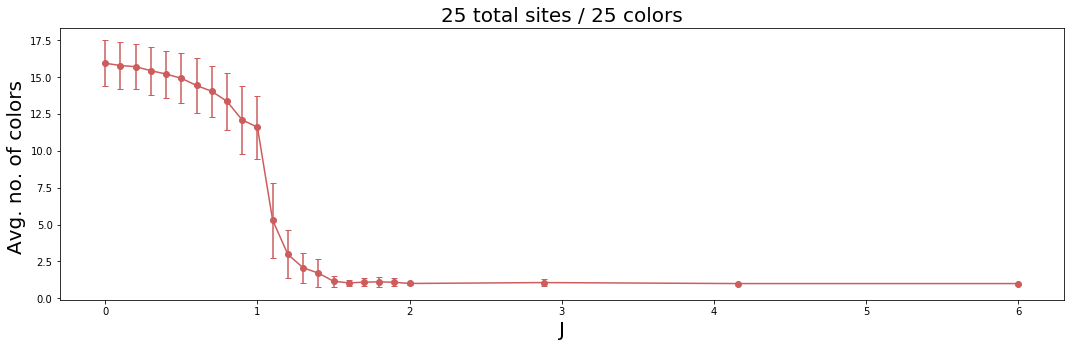

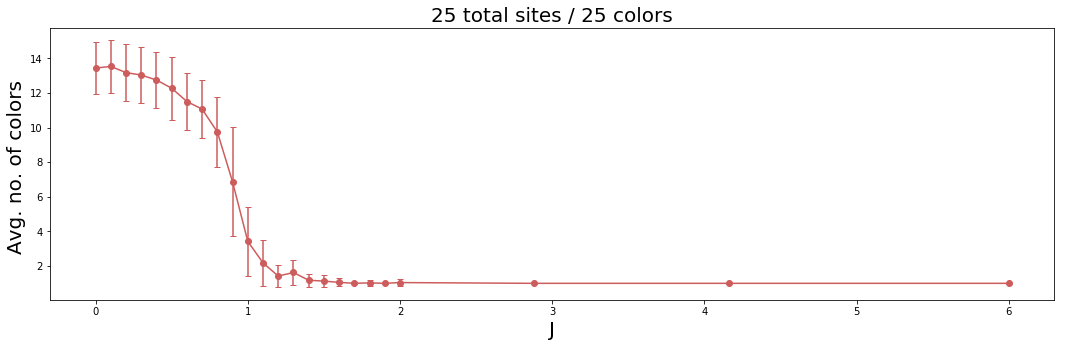

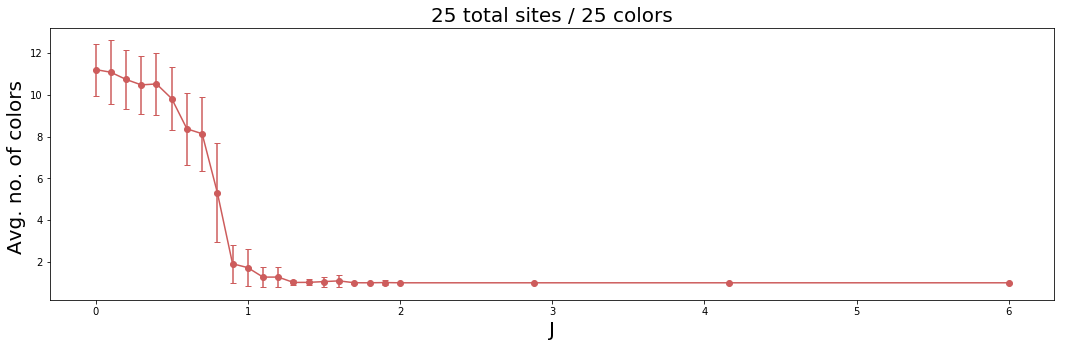

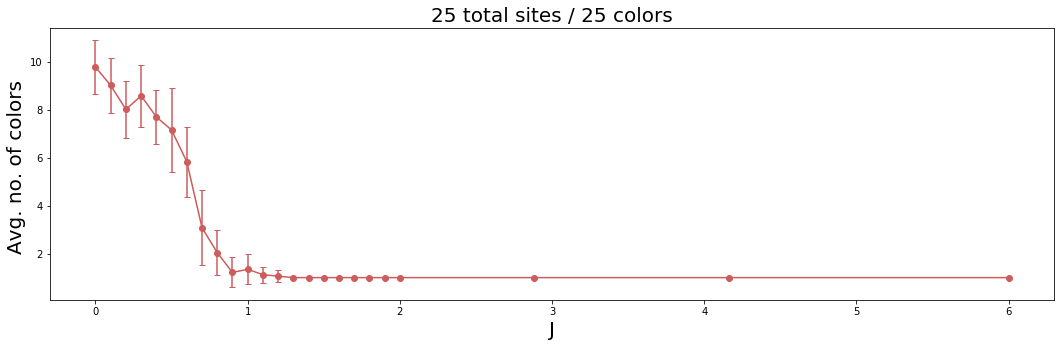

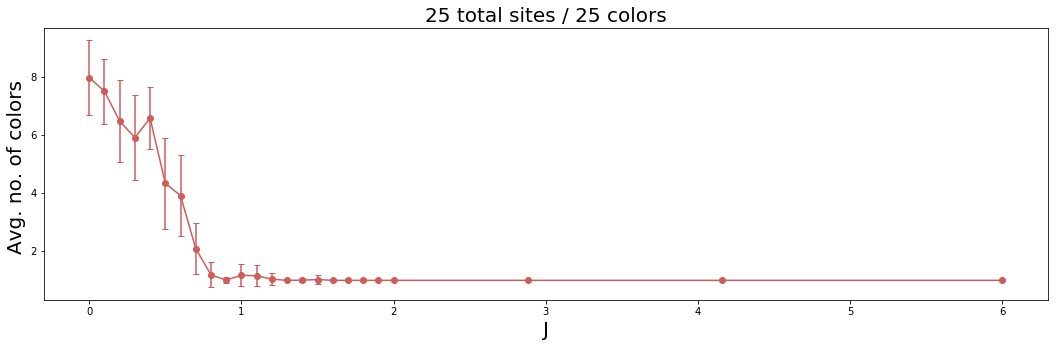

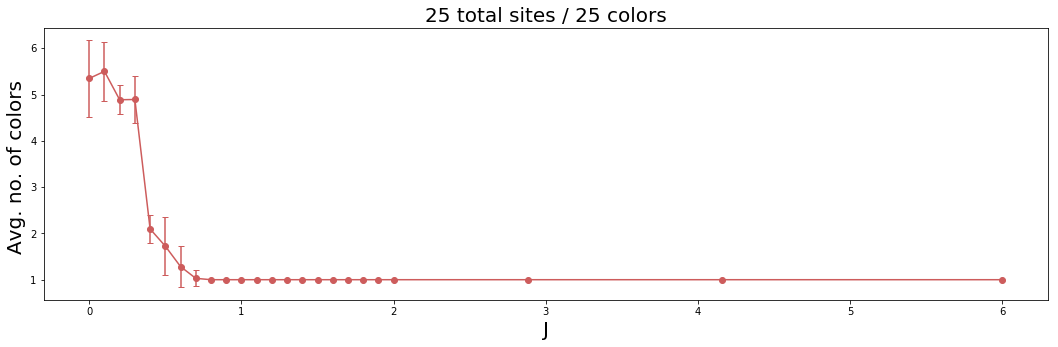

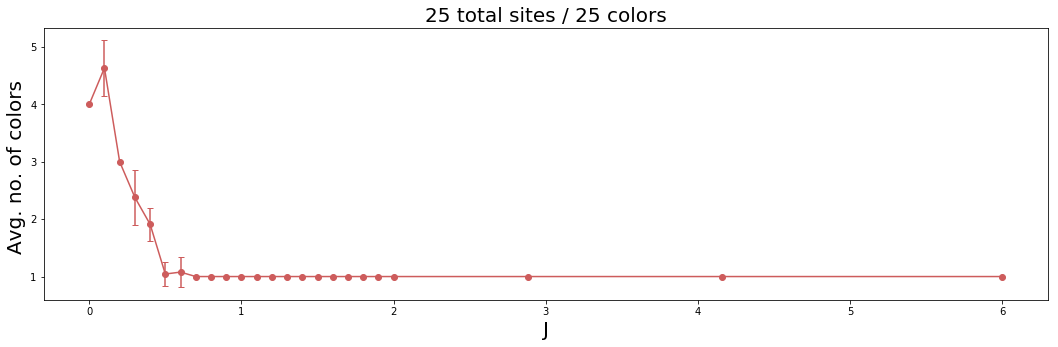

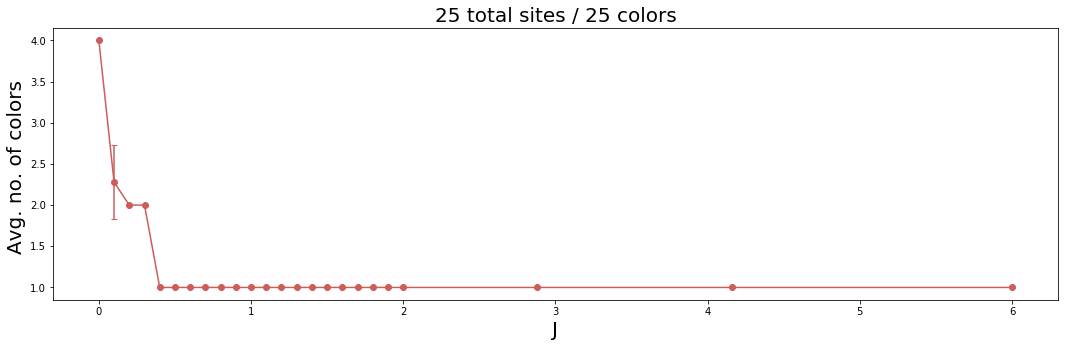

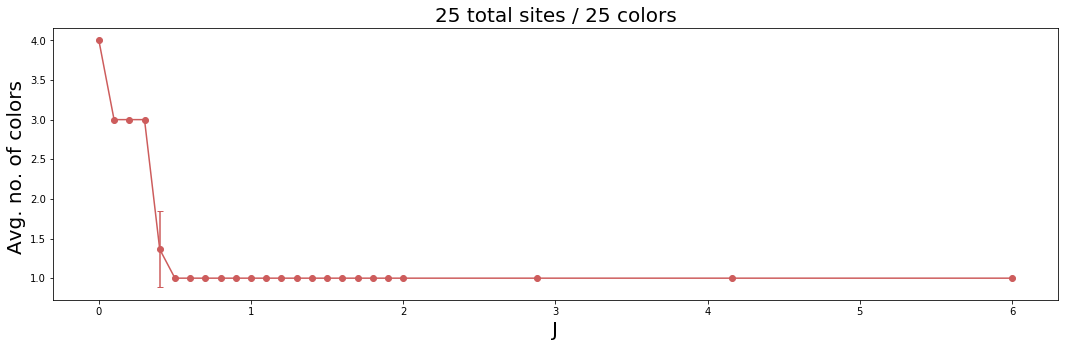

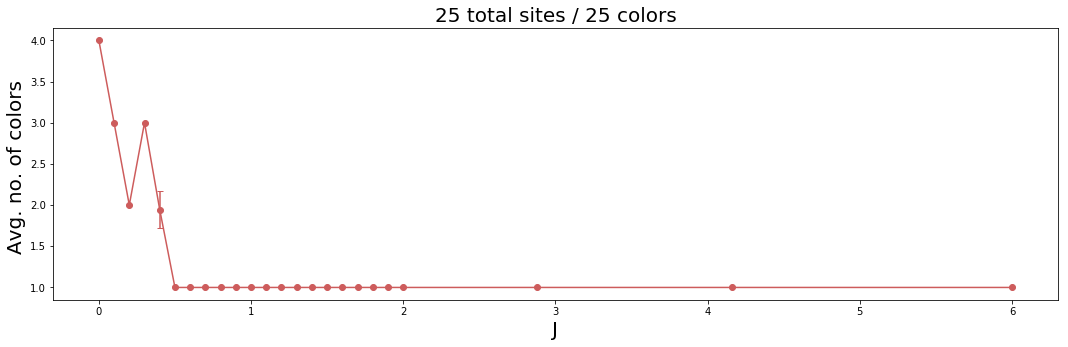

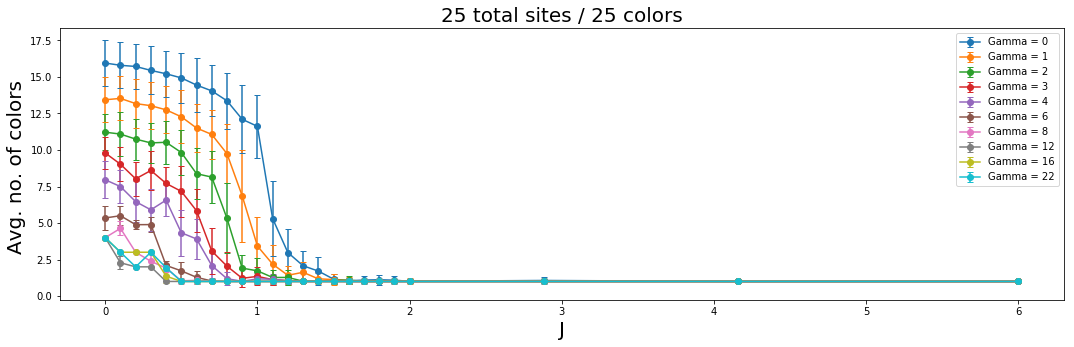

        J  Gamma  Avg. no. of colors      Std.
0    0.00    0.0           15.954229  1.554289
1    0.10    0.0           15.800000  1.564787
2    0.20    0.0           15.721393  1.524588
3    0.30    0.0           15.449751  1.639898
4    0.40    0.0           15.219900  1.591770
5    0.50    0.0           14.936318  1.701016
6    0.60    0.0           14.445771  1.857162
7    0.70    0.0           14.048756  1.741107
8    0.80    0.0           13.370149  1.930201
9    0.90    0.0           12.104478  2.324010
10   1.00    0.0           11.619900  2.138675
11   1.10    0.0            5.308458  2.545971
12   1.20    0.0            2.980100  1.634090
13   1.30    0.0            2.075622  1.032917
14   1.40    0.0            1.710448  0.973653
15   1.50    0.0            1.160199  0.366791
16   1.60    0.0            1.045771  0.218303
17   1.70    0.0            1.093532  0.291177
18   1.80    0.0            1.116418  0.332904
19   1.90    0.0            1.087562  0.282657
20   2.00    

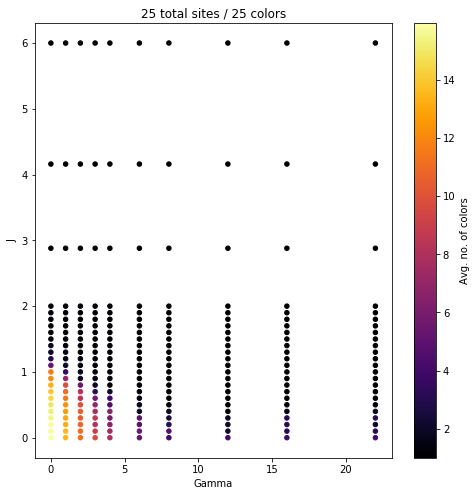

In [111]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

params, avg_c, std_c = [], [], []
gammas = [0,1,2,3,4,6,8,12,16,22]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
save_to_csv_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 21.0 avg. sites per col: 1.7142857142857142
101 num. cols: 22.980198019801982 avg. sites per col: 1.57813466155628
201 num. cols: 23.114427860696516 avg. sites per col: 1.5681783293306908
301 num. cols: 23.006644518272424 avg. sites per col: 1.5759806716264

1001 num. cols: 21.93806193806194 avg. sites per col: 1.6531542056409556
Final configuration:
[[ 1 20 35 36  7 32]
 [26 22  2  5 27 15]
 [24 31 23 11 34 20]
 [ 2 36 23 23 16 24]
 [27 36 22 19 28 19]
 [ 8  8 15 11 15  8]]
Final averages: 21.940298507462686 1.652969525207572
Final stds: 1.8657472621490507 0.14389486898520235
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 21.0 avg. sites per col: 1.7142857142857142
101 num. cols: 21.386138613861387 avg. sites per col: 1.6946800163368614
201 num. cols: 21.34328358208955 avg. sites per col: 1.7001735770733624
301 num. cols: 21.259136212624586 avg. sites per col: 1.707864909331333
401 num. cols: 21.24937655860349 avg. sites per col: 1.708659146081728
5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 9.0
101 num. cols: 3.0396039603960396 avg. sites per col: 12.819801980198022
201 num. cols: 2.557213930348259 avg. sites per col: 16.740298507462686
301 num. cols: 3.1362126245847177 avg. sites per col: 14.68898908400568
401 num. cols: 3.8229426433915212 avg. sites per col: 13.002173138582087
501 num. cols: 3.7465069860279443 avg. sites per col: 12.834473909324178
601 num. cols: 3.8502495840266224 avg. sites per col: 12.14625623960063
701 num. cols: 3.664764621968616 avg. sites per col: 12.543937232524938
801 num. cols: 3.588014981273408 avg. sites per col: 12.643820224719093
901 num. cols: 3.742508324084351 avg. sites per col: 12.252941176470584
1001 num. cols: 3.911088911088911 avg. sites per col: 11.738461538461545
Final configuration:
[[ 2 17 17 17 17 36]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 17 17 17 17 17]
 [17 

201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.196013289036545 avg. sites per col: 32.47176079734219
401 num. cols: 1.2369077306733167 avg. sites per col: 31.7356608478803
501 num. cols: 1.1896207584830338 avg. sites per col: 32.58682634730539
601 num. cols: 1.1580698835274543 avg. sites per col: 33.15474209650582
701 num. cols: 1.2938659058487874 avg. sites per col: 31.54493580599144
801 num. cols: 1.3295880149812733 avg. sites per col: 30.872659176029963
901 num. cols: 1.293007769145394 avg. sites per col: 31.44173140954495
1001 num. cols: 1.2947052947052946 avg. sites per col: 31.375624375624376
Final configuration:
[[11 11 11 11 11 23]
 [11 11 11 11 11 12]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]
 [11 11 11 11 11 11]]
Final averages: 1.3014925373134327 31.29850746268657
Final stds: 0.5898374522642337 8.386938895746713
------------------------------------------------------------------------------------------------------------------------

19  - pa

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 18.0 avg. sites per col: 2.0
101 num. cols: 19.564356435643564 avg. sites per col: 1.8594448092579576
201 num. cols: 19.63681592039801 avg. sites per col: 1.8499864352187965
301 num. cols: 19.82059800664452 avg. sites per col: 1.8329637758219408
401 num. cols: 19.4214463840399 avg. sites per col: 1.8786739420434573
501 num. cols: 19.429141716566868 avg. sites per col: 1.8754252853398943
601 num. cols: 19.55241264559068 avg. sites per col: 1.863366712805732
701 num. cols: 19.510699001426534 avg. sites per col: 1.8668912501821626
801 num. cols: 19.43570536828964 avg. sites per col: 1.8731713114857604
901 num. cols: 19.436182019977803 avg. sites per col: 1.872248985265498
1001 num. cols: 19.46853146853147 avg. sites per col: 1.8689629952193043
Final configuration:
[[28 32  3  2 28 30]
 [29 27  8  4  7  8]
 [28 12 14 27 12 30]
 [ 4  2 27 25 32 17]
 [33 3

equilibration step: 5000
1 num. cols: 17.0 avg. sites per col: 2.1176470588235294
101 num. cols: 16.782178217821784 avg. sites per col: 2.1587479911193266
201 num. cols: 17.29850746268657 avg. sites per col: 2.099979700576195
301 num. cols: 16.87375415282392 avg. sites per col: 2.1580650229563147
401 num. cols: 16.543640897755612 avg. sites per col: 2.2024127134233114
501 num. cols: 16.6626746506986 avg. sites per col: 2.189906087884597
601 num. cols: 16.434276206322796 avg. sites per col: 2.2241246008598483
701 num. cols: 16.59914407988588 avg. sites per col: 2.201649498497104
801 num. cols: 16.403245942571786 avg. sites per col: 2.234949851393983
901 num. cols: 16.475027746947834 avg. sites per col: 2.2233430892292034
1001 num. cols: 16.547452547452547 avg. sites per col: 2.212771913571891
Final configuration:
[[33 13 34  7 19 16]
 [ 7  7 19  7 30 17]
 [ 5 17 30 27 19 17]
 [ 7 17 30 13 18 34]
 [ 9 31 13 13 29 31]
 [ 9 28  5  3 29 29]]
Final averages: 16.545273631840796 2.212920085060

201 num. cols: 1.7114427860696517 avg. sites per col: 26.85373134328358
301 num. cols: 1.5182724252491695 avg. sites per col: 29.11495016611295
401 num. cols: 1.5486284289276808 avg. sites per col: 28.437905236907728
501 num. cols: 1.5009980039920159 avg. sites per col: 28.833532934131732
601 num. cols: 1.4176372712146423 avg. sites per col: 30.025956738768716
701 num. cols: 1.7788873038516406 avg. sites per col: 27.391522315060143
801 num. cols: 1.8601747815230962 avg. sites per col: 26.31268057784914
901 num. cols: 1.8879023307436182 avg. sites per col: 25.31682257808786
1001 num. cols: 1.899100899100899 avg. sites per col: 24.585871271585575
Final configuration:
[[14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [14 14 14 14 14 14]
 [15 14 14 14 14 14]]
Final averages: 1.899502487562189 24.55965884861409
Final stds: 1.11830083940179 10.803218928051256
---------------------------------------------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
equilibration step: 0
equilibration step: 1000
equi

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 18.0 avg. sites per col: 2.0
101 num. cols: 15.465346534653465 avg. sites per col: 2.3432936312377226
201 num. cols: 15.83084577114428 avg. sites per col: 2.297347711820238
301 num. cols: 15.813953488372093 avg. sites per col: 2.3025216752740016
401 num. cols: 15.633416458852867 avg. sites per col: 2.3259943395008134
501 num. cols: 15.417165668662674 avg. sites per col: 2.3575554263500353
601 num. cols: 15.256239600665557 avg. sites per col: 2.383253466293864
701 num. cols: 15.1169757489301 avg. sites per col: 2.4050457150292504
801 num. cols: 15.027465667915106 avg. sites per col: 2.419657805350237
901 num. cols: 14.824639289678135 avg. sites per col: 2.4560256036833614
1001 num. cols: 14.715284715284715 avg. sites per col: 2.481730126592556
Final configuration:
[[34 33  8 22  3 28]
 [33 27 33 22  6 28]
 [10 10 33 34 27  3]
 [28  8 10 22 15  3]
 [28

101 num. cols: 1.3465346534653466 avg. sites per col: 29.762376237623762
201 num. cols: 1.9751243781094527 avg. sites per col: 22.582089552238806
301 num. cols: 1.73421926910299 avg. sites per col: 26.023255813953487
401 num. cols: 1.8778054862842892 avg. sites per col: 23.55860349127182
501 num. cols: 1.816367265469062 avg. sites per col: 24.40119760479042
601 num. cols: 2.0083194675540765 avg. sites per col: 22.71514143094843
701 num. cols: 1.9144079885877319 avg. sites per col: 23.711554921540664
801 num. cols: 1.8064918851435705 avg. sites per col: 25.13333333333334
901 num. cols: 1.974472807991121 avg. sites per col: 23.675693673695918
1001 num. cols: 1.937062937062937 avg. sites per col: 23.851948051948074
Final configuration:
[[6 6 6 6 6 9]
 [6 6 6 6 6 9]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]]
Final averages: 1.9373134328358208 23.82865671641793
Final stds: 1.0371462695044138 10.789365258123441
---------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]
 [32 32 32 32 32 32]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

   params      avg_c     std_c   avg_s_c   std_s_c
0     0.0  16.106468  1.97

601 num. cols: 11.29450915141431 avg. sites per col: 3.374230511584929
701 num. cols: 11.477888730385164 avg. sites per col: 3.3030599215335528
801 num. cols: 11.731585518102372 avg. sites per col: 3.226368824683455
901 num. cols: 11.815760266370699 avg. sites per col: 3.1986644321272752
1001 num. cols: 11.735264735264735 avg. sites per col: 3.2084609196997085
Final configuration:
[[ 5  4  4 22 14 36]
 [35  4  4 13 35 13]
 [18 18 22 22 28  7]
 [18 36  5 32 32 32]
 [18 18 18 36 13 31]
 [20 32 31  4 31 31]]
Final averages: 11.740298507462686 3.20671273999635
Final stds: 2.3746626700366167 0.7100498679966675
------------------------------------------------------------------------------------------------------------------------

5  - param: 0.5
edge probabilities: [0.63212056 0.36787944]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 4.0
101 num. cols: 9.

901 num. cols: 1.48834628190899 avg. sites per col: 28.44173140954495
1001 num. cols: 1.4825174825174825 avg. sites per col: 28.423576423576424
Final configuration:
[[27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 27 27 27 27 27]
 [27 32 27 27 27 27]]
Final averages: 1.4845771144278608 28.382089552238806
Final stds: 0.674342093435326 9.550664982288964
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 18.0
101 num. cols: 1.683168316831683 avg. sites per col: 23.702970297029704
201 num. cols: 1.5223880597014925 avg. sites per col: 26.597014925373134
301 num. cols: 1.3488372093023255 avg. sites per col: 29.72093023255814
401 num. cols: 1.

501 num. cols: 10.502994011976048 avg. sites per col: 3.463944837597526
601 num. cols: 10.522462562396006 avg. sites per col: 3.4598582781610916
701 num. cols: 10.843081312410842 avg. sites per col: 3.3763503258510386
801 num. cols: 10.757802746566792 avg. sites per col: 3.399641058068029
901 num. cols: 10.691453940066593 avg. sites per col: 3.416066730162179
1001 num. cols: 10.658341658341659 avg. sites per col: 3.4227261250238277
Final configuration:
[[27  9  9 25 14 17]
 [ 2 22 22 18  8 17]
 [ 8  1  1 25 17 27]
 [ 1  9  5 18 14  9]
 [17  5  5 27 18 12]
 [14 12 25 12 18 18]]
Final averages: 10.6636815920398 3.421043632983932
Final stds: 1.3204568703208617 0.37048186693640495
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibrat

701 num. cols: 2.37660485021398 avg. sites per col: 22.639942938659143
801 num. cols: 2.578027465667915 avg. sites per col: 21.005243445692997
901 num. cols: 2.4539400665926747 avg. sites per col: 21.817092119866917
1001 num. cols: 2.4265734265734267 avg. sites per col: 21.615584415584507
Final configuration:
[[20 20 15 20 20 20]
 [20 20  9 20 20 20]
 [20 20  9 20 20 15]
 [20 20 20 20 20 20]
 [20  9  9 20 20 20]
 [20 20 20 20 20 20]]
Final averages: 2.4288557213930346 21.57731343283591
Final stds: 1.4579216393712207 12.14315452168755
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 18.0
101 num. cols: 2.0 avg. sites per col: 18.0
201 num. cols: 1.7263681592039801 avg. sites 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0099502487562189 avg. sites per col: 35.82089552238806
301 num. cols: 1.212624584717608 avg. sites per col: 32.17275747508306
401 num. cols: 1.1596009975062345 avg. sites per col: 33.12718204488778
501 num. cols: 1.127744510978044 avg. sites per col: 33.70059880239521
601 num. cols: 1.1064891846921796 avg. sites per col: 34.08319467554077
701 num. cols: 1.0912981455064195 avg. sites per col: 34.35663338088445
801 num. cols: 1.079900124843945 avg. sites per col: 34.561797752808985
901 num. cols: 1.0710321864594894 avg. sites per col: 34.72142064372919
1001 num. cols: 1.063936063936064 avg. sites per col: 34.84915084915085
Final configuration:
[[8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]
 [8 8 8 8 8 8]]
Final averages: 1.0636815920398

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 9.0
101 num. cols: 4.316831683168317 avg. sites per col: 8.429702970297043
201 num. cols: 4.656716417910448 avg. sites per col: 7.817910447761224
301 num. cols: 4.770764119601329 avg. sites per col: 7.612624584717618
401 num. cols: 4.827930174563591 avg. sites per col: 7.509725685785498
501 num. cols: 4.930139720558882 avg. sites per col: 7.366467065868209
601 num. cols: 5.108153078202995 avg. sites per col: 7.139101497504115
701 num. cols: 5.1897289586305275 avg. sites per col: 7.031383737517785
801 num. cols: 5.166042446941323 avg. sites per col: 7.052434456928776
901 num. cols: 5.1476137624861265 avg. sites per col: 7.068812430632554
1001 num. cols: 5.1328671328671325 avg. sites per col: 7.081918081917995
Final configuration:
[[19 19 28 19 28 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
equilibration step: 0
equilibration step: 1000
equili

equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 12.0
101 num. cols: 3.0 avg. sites per col: 12.0
201 num. cols: 3.0 avg. sites per col: 12.0
301 num. cols: 3.0 avg. sites per col: 12.0
401 num. cols: 3.0 avg. sites per col: 12.0
501 num. cols: 3.0 avg. sites per col: 12.0
601 num. cols: 3.0 avg. sites per col: 12.0
701 num. cols: 3.0 avg. sites per col: 12.0
801 num. cols: 3.0 avg. sites per col: 12.0
901 num. cols: 3.0 avg. sites per col: 12.0
1001 num. cols: 3.0 avg. sites per col: 12.0
Final configuration:
[[36 36 36 36 36 30]
 [36 36 30 30 36 36]
 [30 30  3 30 36 36]
 [30 30  3  3  3  3]
 [36 30  3  3  3  3]
 [ 3  3 36 36 36 30]]
Final averages: 3.0 12.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 

601 num. cols: 5.0 avg. sites per col: 7.199999999999919
701 num. cols: 5.0 avg. sites per col: 7.199999999999905
801 num. cols: 5.0 avg. sites per col: 7.1999999999998945
901 num. cols: 5.0 avg. sites per col: 7.199999999999886
1001 num. cols: 5.0 avg. sites per col: 7.199999999999879
Final configuration:
[[26 36  2 20 20 24]
 [24 36 20 26 24 24]
 [20  2 26 36 26 36]
 [26 24 20  2  2  2]
 [26 36 24  2 36  2]
 [ 2  2 36 26 36 24]]
Final averages: 5.0 7.1999999999998785
Final stds: 0.0 1.7763568394002505e-15
------------------------------------------------------------------------------------------------------------------------

3  - param: 0.3
edge probabilities: [0.45118836 0.54881164]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 9.0
101 num. cols: 3.1881188118811883 avg. sites per col: 11.435643564356436
201 num. cols: 3.0945273631840795 avg. sites

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 6.0
101 num. cols: 6.0 avg. sites per col: 6.0
201 num. cols: 6.0 avg. sites per col: 6.0
301 num. cols: 6.0 avg. sites per col: 6.0
401 num. cols: 6.0 avg. sites per col: 6.0
501 num. cols: 6.0 avg. sites per col: 6.0
601 num. cols: 6.0 avg. sites per col: 6.0
701 num. cols: 6.0 avg. sites per col: 6.0
801 num. cols: 5.972534332084894 avg. sites per col: 6.032958801498122
901 num. cols: 5.864594894561598 avg. sites per col: 6.1624861265260575
1001 num. cols: 5.778221778221778 avg. sites per col: 6.266133866133826
Final configuration:
[[34 28 20 34 20 28]
 [34  8 30  8 28 34]
 [34 20  8 28 20  8]
 [34 28  8  8  8 30]
 [ 8 34 30 28 20 34]
 [ 8 28 20 30 20 34]]
Final averages: 5.775124378109453 6.269850746268616
Final stds: 0.4175003911014778 0.5010004693217734
--------------------------------------------------------------------

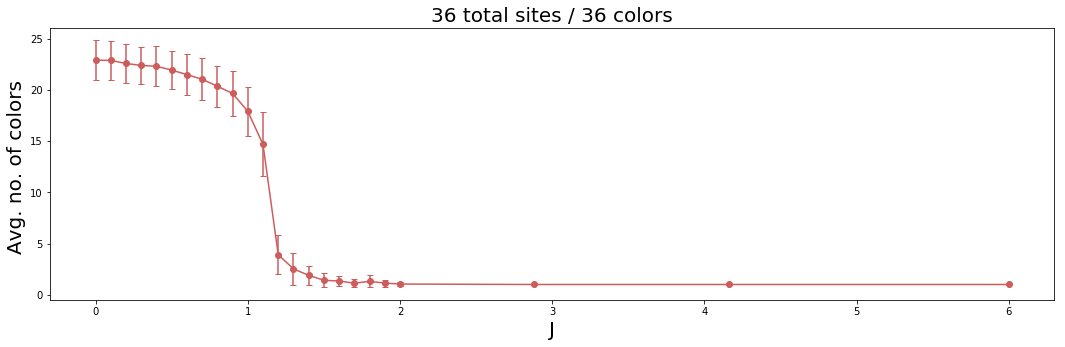

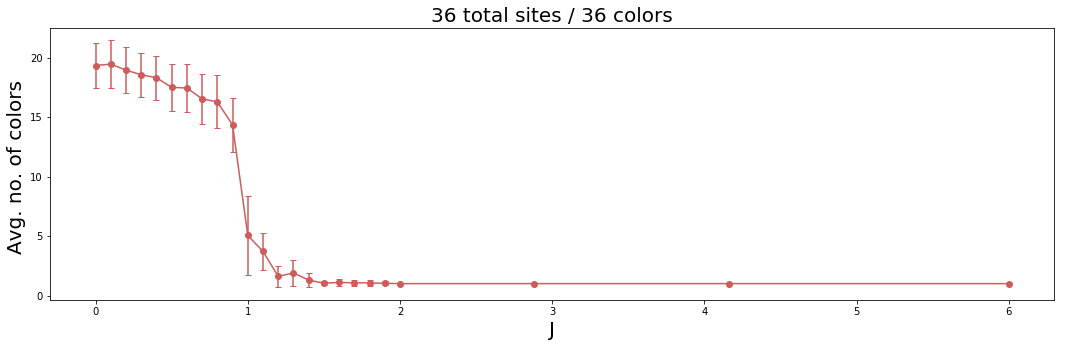

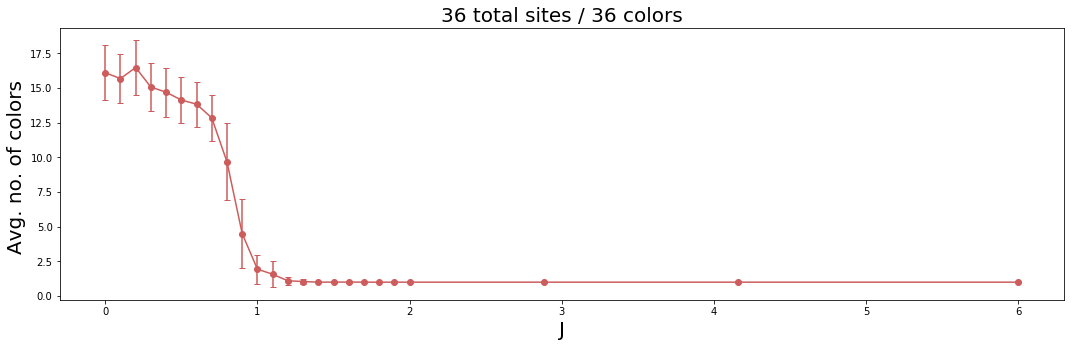

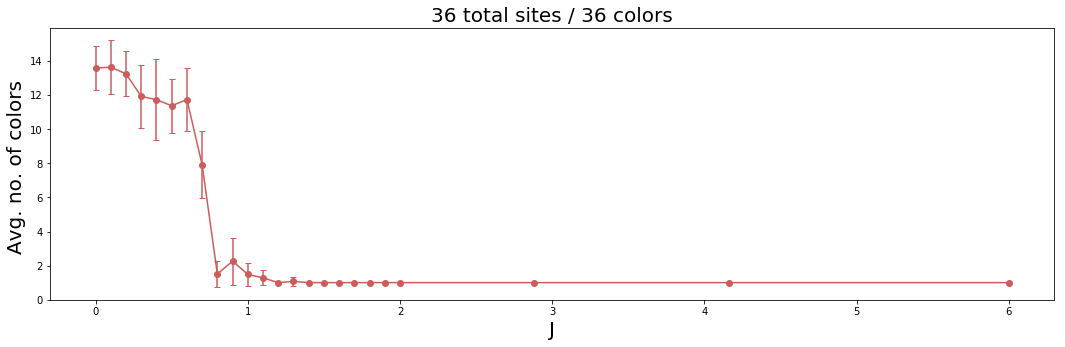

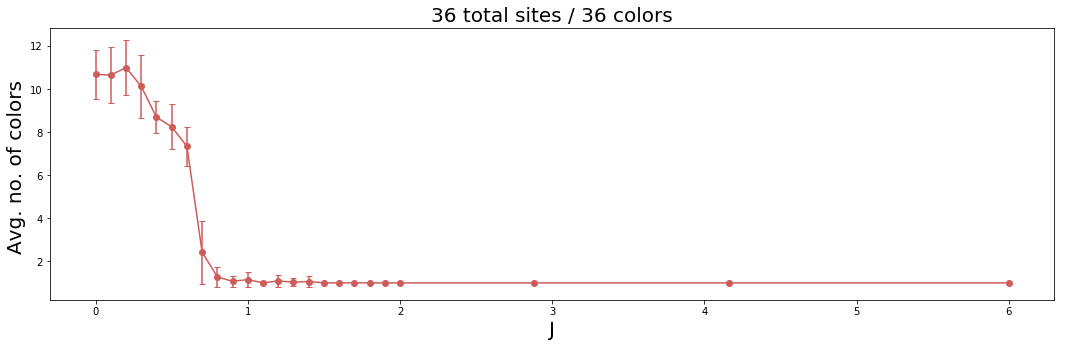

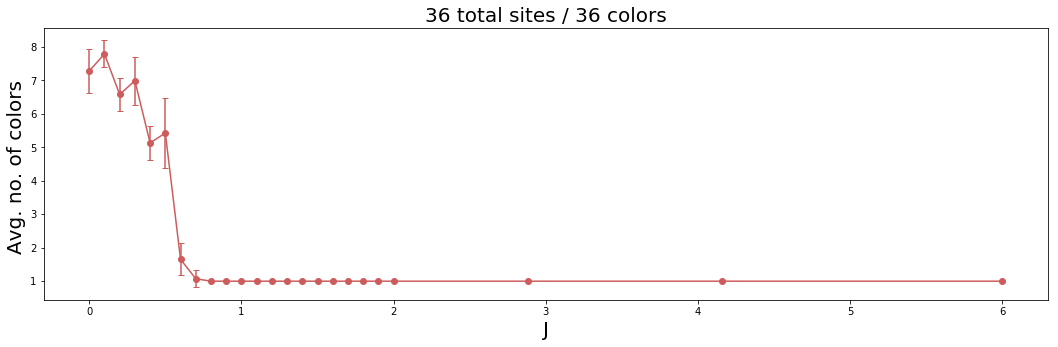

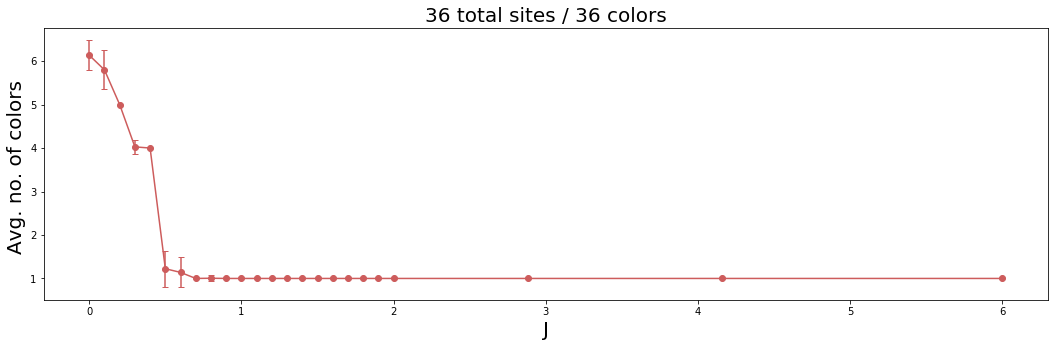

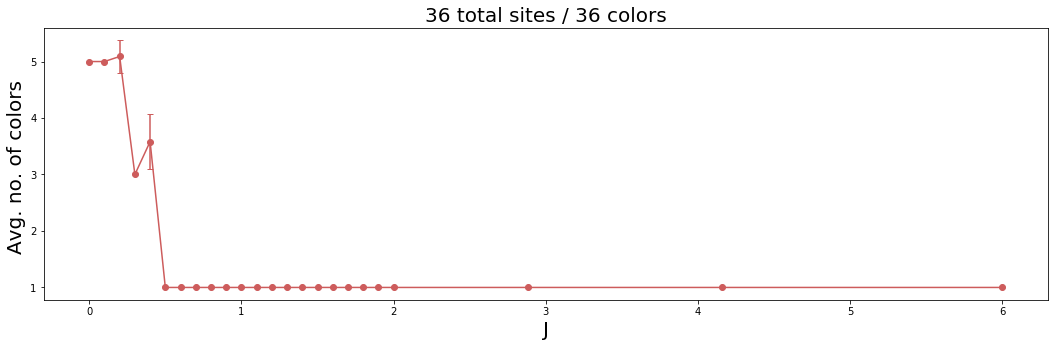

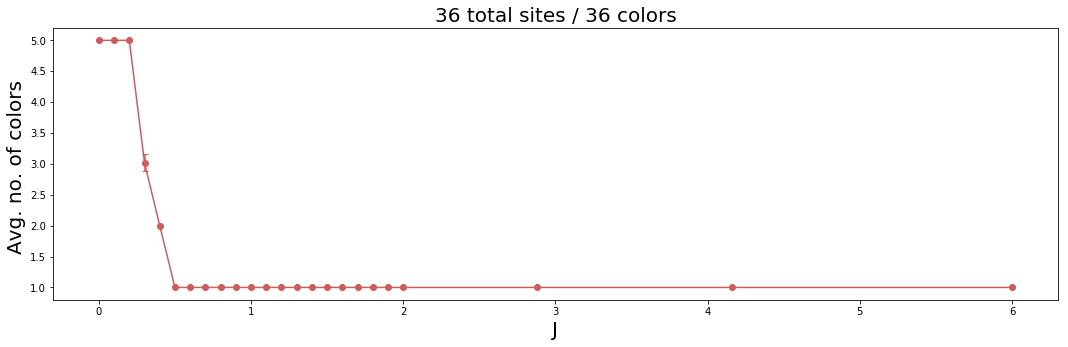

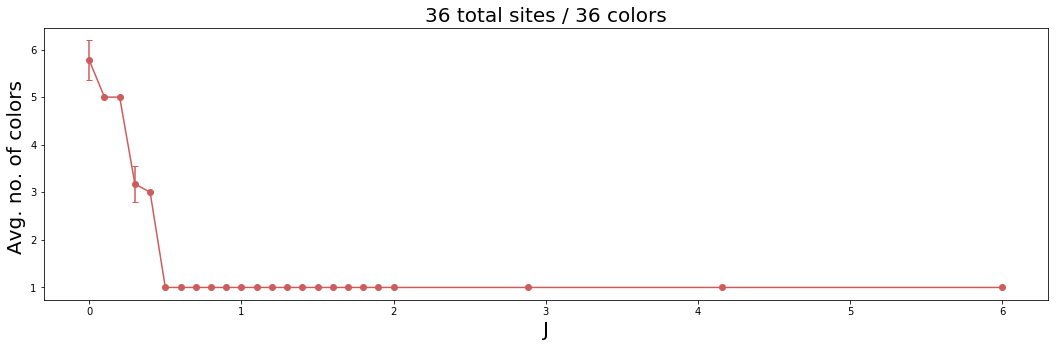

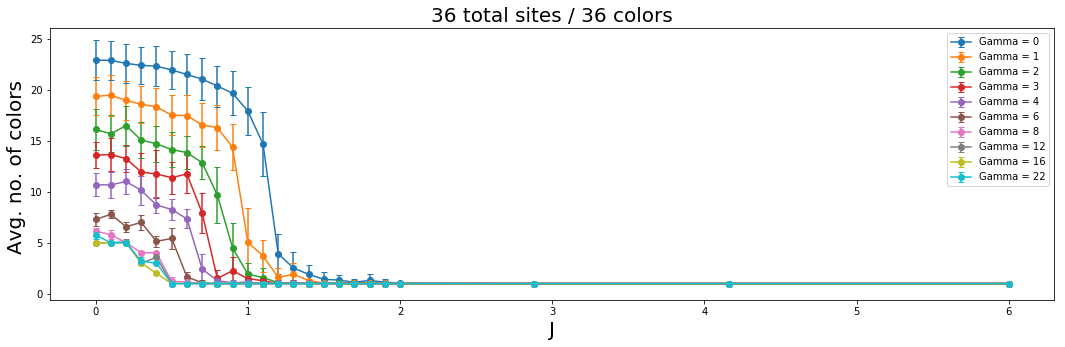

        J  Gamma  Avg. no. of colors      Std.
0    0.00    0.0           22.905473  1.938359
1    0.10    0.0           22.886567  1.890292
2    0.20    0.0           22.584080  1.920340
3    0.30    0.0           22.393035  1.847885
4    0.40    0.0           22.313433  1.935854
5    0.50    0.0           21.940299  1.865747
6    0.60    0.0           21.497512  1.982823
7    0.70    0.0           21.039801  2.048761
8    0.80    0.0           20.365174  2.008683
9    0.90    0.0           19.657711  2.159844
10   1.00    0.0           17.916418  2.367058
11   1.10    0.0           14.677612  3.124537
12   1.20    0.0            3.911443  1.932986
13   1.30    0.0            2.527363  1.564054
14   1.40    0.0            1.897512  0.946554
15   1.50    0.0            1.413930  0.685170
16   1.60    0.0            1.336318  0.520547
17   1.70    0.0            1.129353  0.361291
18   1.80    0.0            1.301493  0.589837
19   1.90    0.0            1.140299  0.347296
20   2.00    

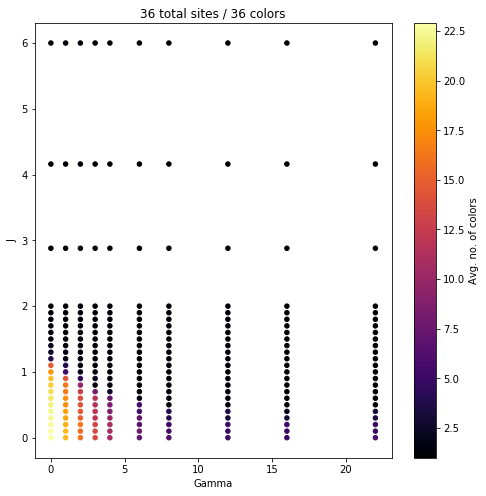

In [112]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

params, avg_c, std_c = [], [], []
gammas = [0,1,2,3,4,6,8,12,16,22]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
save_to_csv_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 7

params, avg_c, std_c = [], [], []
gammas = [3,4,6,8,12,16] # 0,1,2 in csv!
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
save_to_csv_multiple (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")
plot_phase (N, N*N, params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 3 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [9.50212932e-01 4.73083162e-02 2.35534237e-03 1.17265592e-04
 5.83831003e-06 2.90672341e-07 1.44717237e-08 7.20504697e-10
 3.58718166e-11 1.78595259e-12 8.89173435e-14 4.42693386e-15
 2.20404059e-16 1.09732719e-17 5.46327041e-19 2.72000217e-20
 1.35420934e-21 6.74221131e-23 3.35674935e-24 1.67122709e-25
 8.32054976e-27 4.14255780e-28 2.06245808e-29 1.02683742e-30
 5.11232246e-32 2.54527548e-33 1.26721804e-34 6.30910714e-36
 3.14111948e-37 1.56387130e-38 7.78605676e-40 3.87644940e-41
 1.92997051e-42 9.60875739e-44 4.78391861e-45 2.38177283e-46
 1.18581487e-47 5.90382459e-49 2.93934118e-50 1.46341180e-51
 7.28589835e-53 3.62743520e-54 1.80599364e-55 8.99151289e-5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 3.5
101 num. cols: 15.623762376237623 avg. sites per col: 3.169212724439865
201 num. cols: 15.199004975124378 avg. sites per col: 3.2473675488820315
301 num. cols: 15.305647840531561 avg. sites per col: 3.2236587568837867
401 num. cols: 15.276807980049876 avg. sites per col: 3.2269906399160435
501 num. cols: 15.359281437125748 avg. sites per col: 3.2082649306715876
601 num. cols: 15.732113144758735 avg. sites per col: 3.1381063111100924
701 num. cols: 15.874465049928673 avg. sites per col: 3.1119411285684233
801 num. cols: 15.990012484394507 avg. sites per col: 3.0882762711834846
901 num. cols: 16.11764705882353 avg. sites per col: 3.063488530263033
1001 num. cols: 16.1988011988012 avg. sites per col: 3.047892399270721
Final configuration:
[[35 31 29 41 41 36 32]
 [19 13 43 41 44 26  8]
 [ 9 44 35 41 13 13 31]
 [31  4  7  7  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0764119601328903 avg. sites per col: 47.127906976744185
401 num. cols: 1.0822942643391522 avg. sites per col: 46.98379052369077
501 num. cols: 1.0658682634730539 avg. sites per col: 47.38622754491018
601 num. cols: 1.0965058236272878 avg. sites per col: 46.635607321131445
701 num. cols: 1.1925820256776034 avg. sites per col: 44.28174037089872
801 num. cols: 1.3283395755305867 avg. sites per col: 41.52663337494795
901 num. cols: 1.2985571587125415 avg. sites per col: 42.192933777284466
1001 num. cols: 1.2687312687312686 avg. sites per col: 42.87296037296035
Final configuration:
[[42 42 42 42 42 42 42]
 [42 42 42 42 42 42 42]
 [42 42 42 42 42 42 42]
 [42 42 42 42 42 42 42]
 [42 42 42 42 42 42 42]
 [42 42 42 42 42 42 42]


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 3.5
101 num. cols: 16.178217821782177 avg. sites per col: 3.0457845010507247
201 num. cols: 16.442786069651742 avg. sites per col: 2.9916616393437003
301 num. cols: 16.60797342192691 avg. sites per col: 2.9610654114767017
401 num. cols: 16.55860349127182 avg. sites per col: 2.9679417941215114
501 num. cols: 16.447105788423155 avg. sites per col: 2.9868156875104312
601 num. cols: 16.264559068219633 avg. sites per col: 3.0226547300766375
701 num. cols: 16.095577746077034 avg. sites per col: 3.055757954506982
801 num. cols: 15.833957553058676 avg. sites per col: 3.1112188840317034
901 num. cols: 15.69478357380688 avg. sites per col: 3.1395427222819876
1001 num. cols: 15.594405594405595 avg. sites per col: 3.159468524251834
Final configuration:
[[18 16 18  8 26 36 24]
 [38 24 38 44 19 44 15]
 [ 8 16 18 16 17 24 44]
 [38 47 15 24 

In [470]:
import pandas as pd
def plot_phase (N, no_cols, param_name, param_name2, save_opts=""):
    df = pd.read_csv("Simulation_all_interaction_data/avg_std_("
                        + str(N)+ "," + str(no_cols) + ")"
                        + "_vary_" + param_name
                        + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                        + save_opts + ".csv")
    
    df["Avg. no. of colors"] = [int(x) for x in df["Avg. no. of colors"]]
    df = df[df['J']<=2]
    df = df[df['Gamma']<=12]
    df = df[df['Avg. no. of colors']>1]
    print(df.head())
    
    df.plot.scatter(x=param_name2,
                    y=param_name,
                    c="Avg. no. of colors",
                    cmap="gnuplot2",
                    title = str(N*N) + " total sites / " + str(no_cols) + " colors",
                    figsize = (6,4))
    
    plt.savefig("Simulation_all_interaction/phase_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")
    plt.show()

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  10  1.232934
1           1  0.1    0.0                  10  1.307750
2           2  0.2    0.0                   9  1.269702
3           3  0.3    0.0                   9  1.354856
4           4  0.4    0.0                   9  1.284288


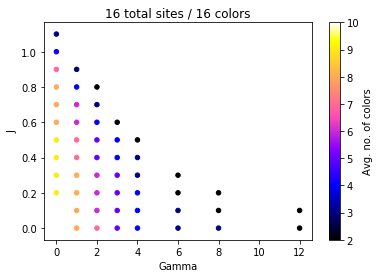

In [471]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 4

plot_phase (N, N*N, "J", "Gamma")

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  15  1.554289
1           1  0.1    0.0                  15  1.564787
2           2  0.2    0.0                  15  1.524588
3           3  0.3    0.0                  15  1.639898
4           4  0.4    0.0                  15  1.591770


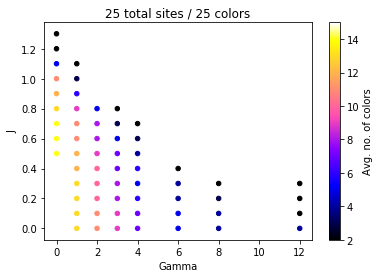

In [472]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 5

plot_phase (N, N*N, "J", "Gamma")

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  22  1.938359
1           1  0.1    0.0                  22  1.890292
2           2  0.2    0.0                  22  1.920340
3           3  0.3    0.0                  22  1.847885
4           4  0.4    0.0                  22  1.935854


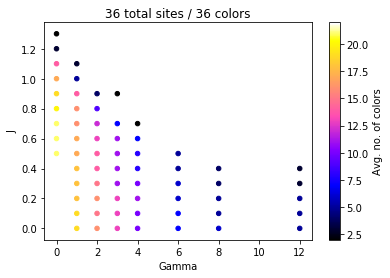

In [473]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 6

plot_phase (N, N*N, "J", "Gamma")